# Prepare Ross Ice Shelf gravity data

import the necessary packages

In [1]:
%load_ext autoreload
%autoreload 2
from antarctic_plots import fetch, regions, utils, maps
import pygmt
import numpy as np
import pandas as pd
import numpy as np
from scipy import stats
import geopandas as gpd
import xarray as xr
import rioxarray
import verde as vd
import harmonica as hm
import pooch
from pyproj import Transformer
import os
os.getcwd()

c:\Users\matthewt\AppData\Local\miniforge3\envs\grav_inv_ant_plots\lib\site-packages\xarray\backends\cfgrib_.py:29: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


'c:\\Users\\matthewt\\Documents\\Python_Scripts\\RIS_gravity_inversion'

# ROSETTA-Ice data

## load data
with antarctic_plots.fetch

                Line       LATITUDE      LONGITUDE      unixtime  \
count  398279.000000  398279.000000  398279.000000  3.982790e+05   
mean      661.219550     -80.571198     -36.741857  1.457515e+09   
std       264.422153       1.786949     165.241996  1.431469e+07   
min        20.000000     -85.389220    -179.999880  1.447367e+09   
25%       470.000000     -81.869075    -169.885715  1.448316e+09   
50%       650.000000     -80.392556    -158.359371  1.449134e+09   
75%       840.000000     -79.145016     171.037900  1.479949e+09   
max      1140.000000     -77.339971     180.000724  1.480734e+09   

              Height              x             y  FAG_levelled  
count  398279.000000  398279.000000  3.982790e+05  3.982790e+05  
mean      793.056619  -84278.810943 -1.000705e+06  4.329633e-15  
std        83.977581  212966.781186  1.984653e+05  1.425479e+01  
min       650.023000 -571781.809097 -1.367767e+06 -2.854953e+02  
25%       744.524000 -240585.860838 -1.160510e+06 -7.3644

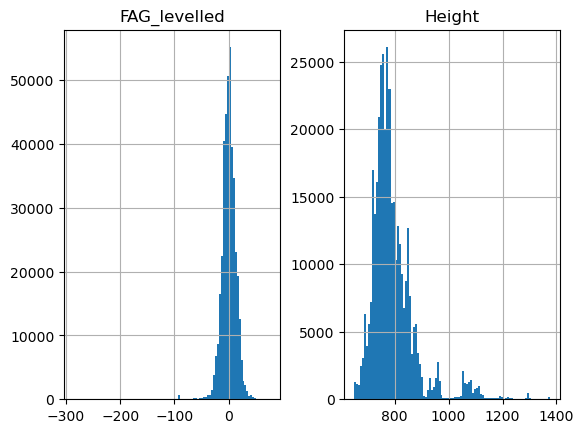

In [2]:
rosetta = fetch.ROSETTA_gravity()

rosetta[['FAG_levelled','Height']].hist(bins=100)
print(rosetta.describe())

In [3]:
# seperate e-w flight lines from n-s tie lines
ties=rosetta[rosetta.Line>=1000]
lines=rosetta[rosetta.Line<1000]

In [4]:
def plot_flightlines(
    fig: pygmt.Figure, 
    df: pd.DataFrame, 
    direction: str = 'EW',
    plot_labels: bool = True,
    plot_lines: bool =True,
    **kwargs
    ):

    # group lines by their line number
    lines = [v for _, v in df.groupby('Line')]

    # plot lines
    if plot_lines is True:
        for i in list(range(len(lines))): 
            fig.plot(
                x=lines[i].x, 
                y=lines[i].y, 
                pen=kwargs.get("pen", '0.3p,white'),
                ) 

    # plot labels
    if plot_labels is True: 
        for i in list(range(len(lines))): 
            # switch label locations for every other line          
            if (i%2) == 0:
                if direction == 'EW':
                    offset='0.25c/0c'
                    # plot label at max value of x-coord
                    x_or_y='x'
                    # angle of label
                    angle=0
                elif direction == 'NS':
                    offset='0c/0.25c'
                    # plot label at max value of y-coord
                    x_or_y='y'
                    # angle of label
                    angle=90
                else: 
                    raise ValueError("invalid direction string")
                # plot label
                fig.text(
                    x=lines[i].x.loc[lines[i][x_or_y].idxmax()], 
                    y=lines[i].y.loc[lines[i][x_or_y].idxmax()], 
                    text=str(lines[i].Line.iloc[0]), 
                    justify='CM', 
                    font=kwargs.get("font", '5p,black'), 
                    fill='white', 
                    offset=offset,
                    angle=angle,
                    )
            else:
                if direction == 'EW':
                    offset='-0.25c/0c'
                    # plot label at max value of x-coord
                    x_or_y='x'
                    # angle of label
                    angle=0
                elif direction == 'NS':
                    offset='0c/-0.25c'
                    # plot label at max value of y-coord
                    x_or_y='y'
                    # angle of label
                    angle=90
                else: 
                    raise ValueError("invalid direction string")
                # plot label
                fig.text(
                    x=lines[i].x.loc[lines[i][x_or_y].idxmin()], 
                    y=lines[i].y.loc[lines[i][x_or_y].idxmin()], 
                    text=str(lines[i].Line.iloc[0]), 
                    justify='CM', 
                    font=kwargs.get("font", '5p,black'), 
                    fill='white', 
                    offset=offset,
                    angle=angle,
                    )

Plot as point data

In [5]:
import math
def round_region(region, spacing):
    
    # round a number up to the nearest multiple of spacing
    def round_up(x, spacing):
        return spacing * math.ceil(x/spacing)
    
    # round a number down to the nearest multiple of spacing
    def round_down(x, spacing):
        return spacing * math.floor(x/spacing)
    
    # round down xmin and ymin, and round up xmax and ymax
    rounded_region = [
        round_down(region[0], spacing),
        round_up(region[1], spacing),
        round_up(region[2], spacing),
        round_down(region[3], spacing),
    ]

    return rounded_region

gmtset [WARNING]: Representation of font type not recognized. Using default.
gmtset [WARNING]: Representation of font type not recognized. Using default.


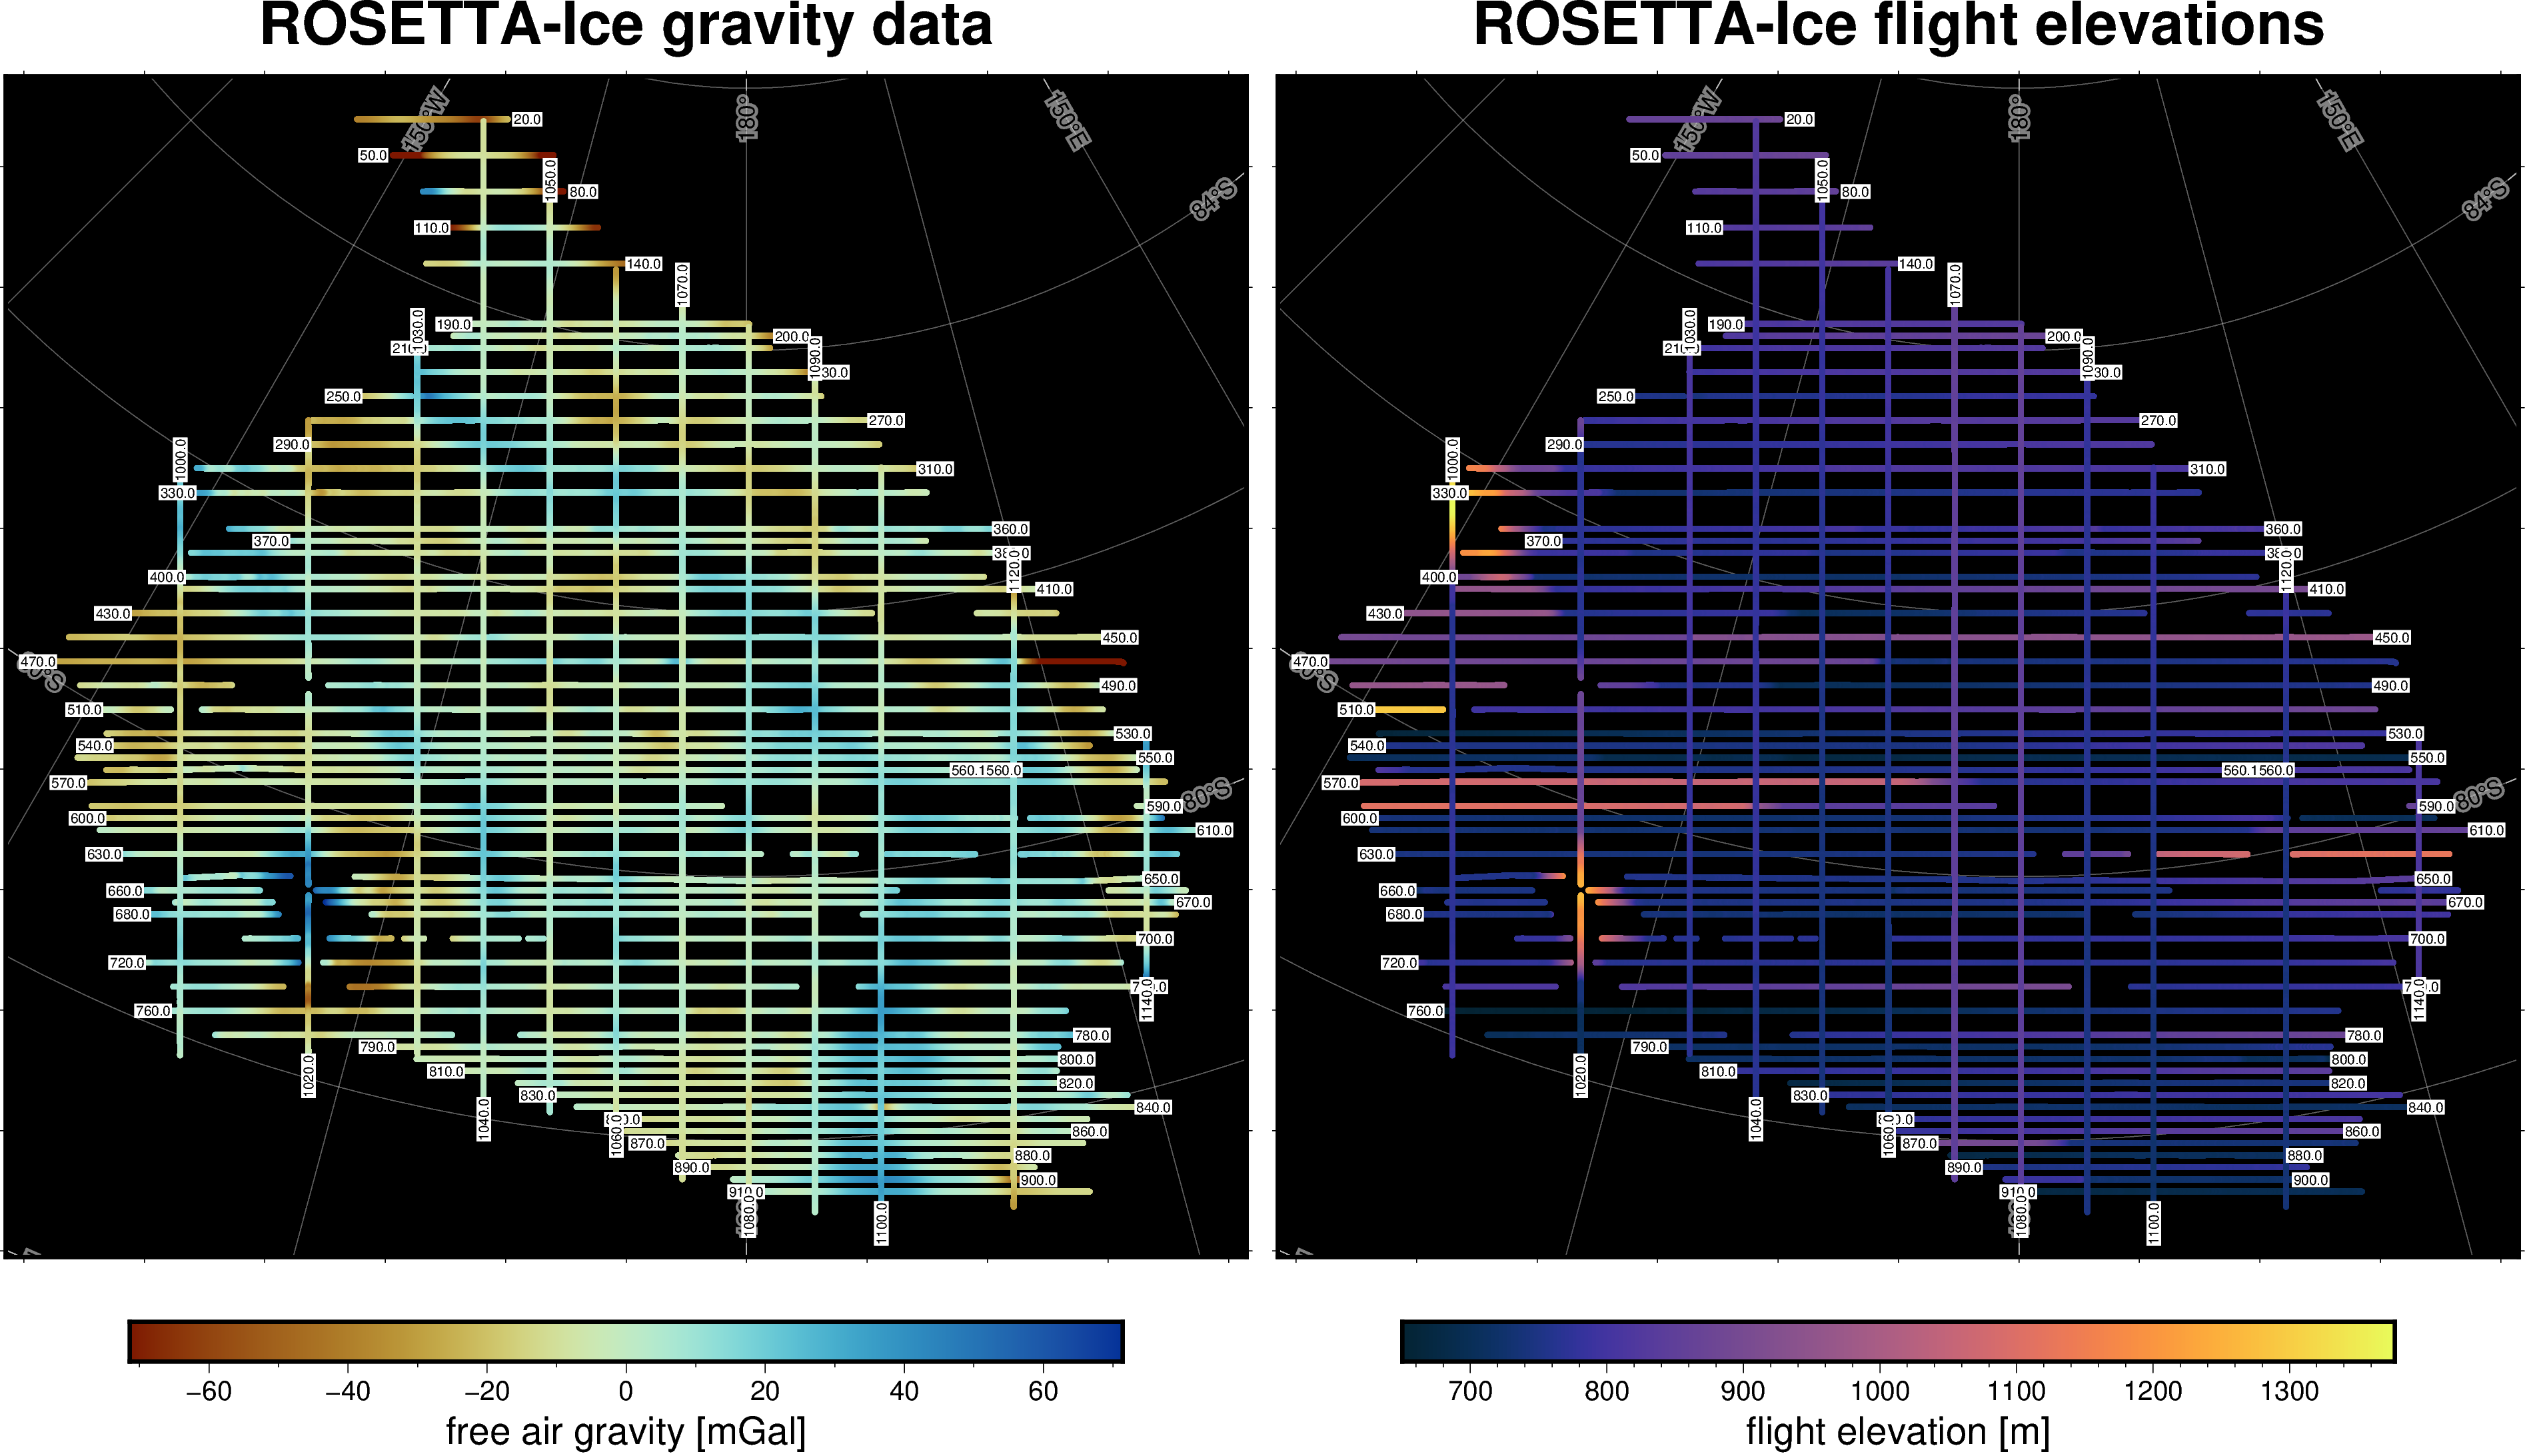

In [6]:
# get bounding region of data
region = vd.get_region((rosetta.x, rosetta.y))
# zoom out by 20 km
region = utils.alter_region(region, zoom=-40e3)[0]
# round to nearest 5km
region = round_region(region, 5e3)

# plot a basemap
fig = maps.basemap(
    region, 
    title="ROSETTA-Ice gravity data",
    background='black',
    )

# get a quarter of max absolute value and make a colorscale
maxabs = vd.maxabs(rosetta.FAG_levelled)*.25
pygmt.makecpt(cmap="roma", series=[-maxabs,maxabs])

# plot gravity data
fig.plot(x=rosetta.x, 
         y=rosetta.y, 
         color=rosetta.FAG_levelled,
         style='c2p',
         cmap=True)

plot_flightlines(fig, lines, plot_lines=False, direction='EW')
plot_flightlines(fig, ties, plot_lines=False, direction='NS')

# plot the colorbar
fig.colorbar(frame='af+l"free air gravity [mGal]"')


# add a second figure to the right
fig = maps.basemap(
    region, 
    title="ROSETTA-Ice flight elevations",
    origin_shift='xshift',
    fig=fig,
    background='black',
    )

# make a colorscale for flight elevations 
pygmt.makecpt(cmap="thermal", series=[rosetta.Height.min(), rosetta.Height.max()])

# plot flight elevation data
fig.plot(x=rosetta.x, 
         y=rosetta.y, 
         color=rosetta.Height,
         style='c2p',
         cmap=True)

plot_flightlines(fig, lines, plot_lines=False, direction='EW')
plot_flightlines(fig, ties, plot_lines=False, direction='NS')

# plot the colorbar
fig.colorbar(frame='af+l"flight elevation [m]"')

fig.show()

Plot as a grids to compare to later

c:\Users\matthewt\AppData\Local\miniforge3\envs\grav_inv_ant_plots\lib\site-packages\xarray\backends\plugins.py:64: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
grd2cpt [ERROR]: Making a continuous cpt from a discrete cpt may give unexpected results!


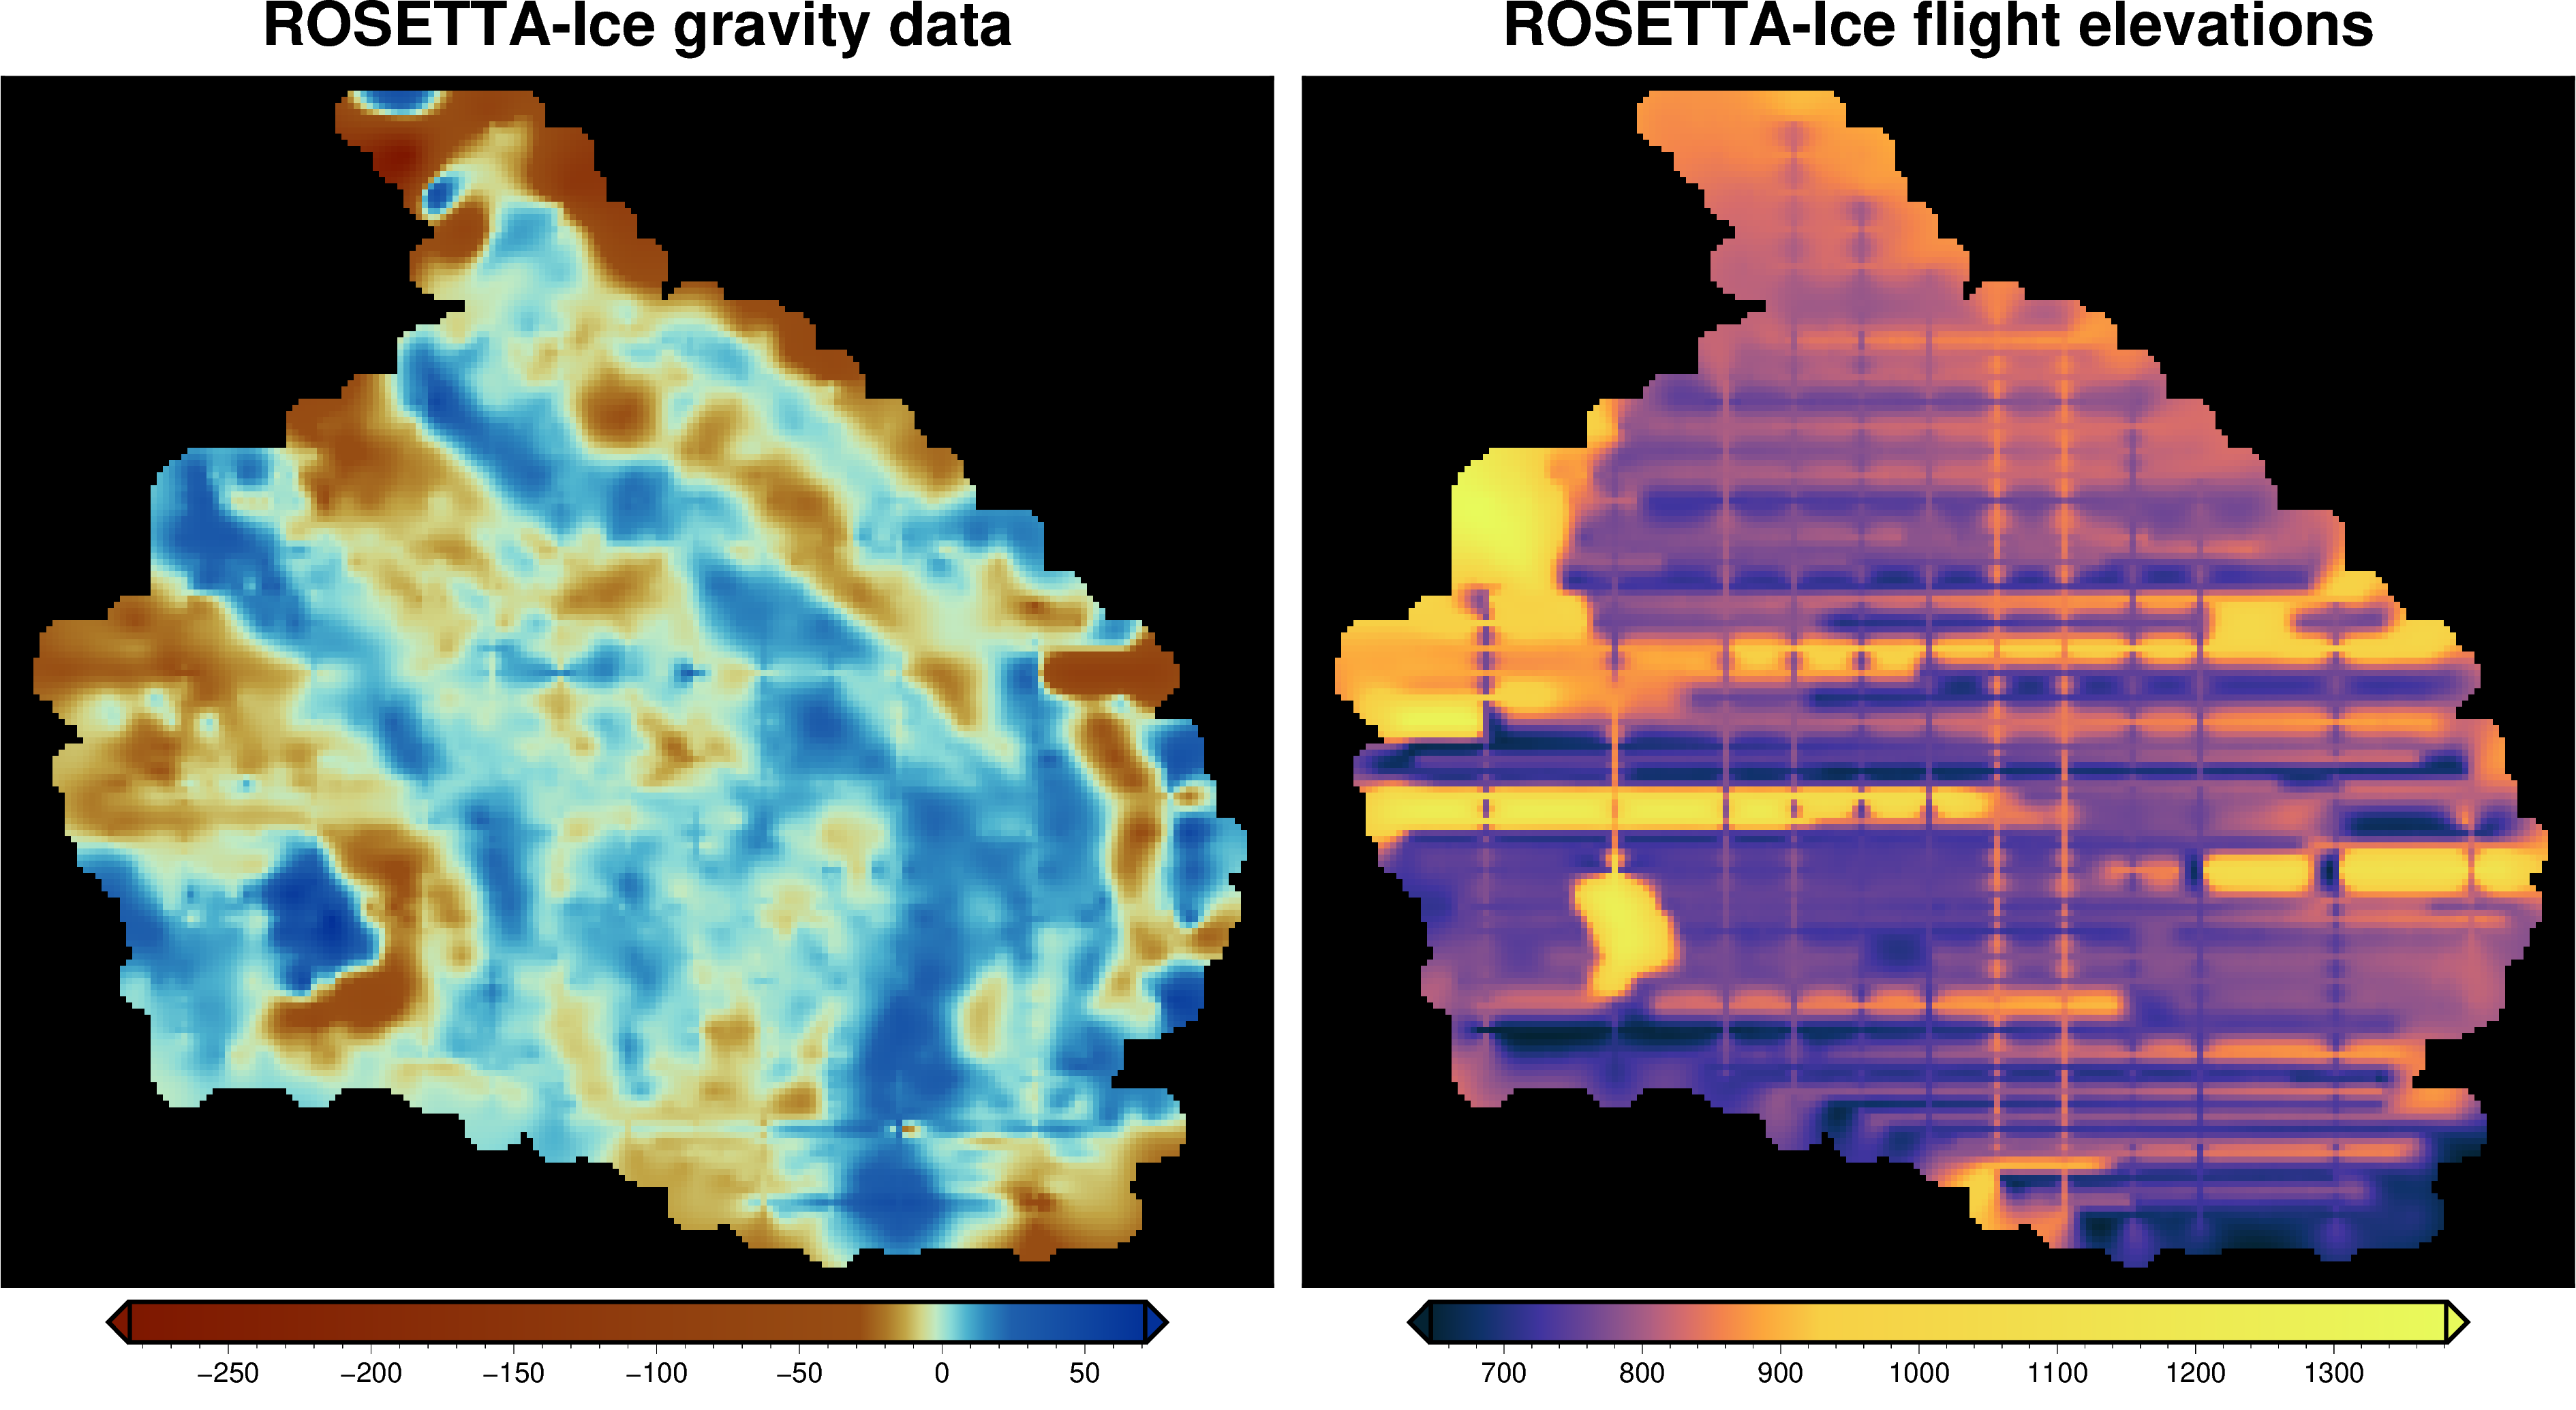

In [7]:
# block the grav data
rosetta_block = pygmt.blockmedian(
    data=rosetta[["x", "y", "FAG_levelled"]], 
    spacing="5000", 
    region=region,
    )
# block the elevation data
rosetta_block_height = pygmt.blockmedian(
    data=rosetta[["x", "y", "Height"]], 
    spacing="5000", 
    region=region,
    )

# grid the blocked grav data
rosetta_grav_grid = pygmt.surface(
    data=rosetta_block,
    spacing='5000+e', 
    M='4c', 
    registration='p',
    region=region,
    ) 

# grid the blocked elevation data
rosetta_elev_grid = pygmt.surface(
    data=rosetta_block_height,
    spacing='5000+e', 
    M='4c', 
    registration='p',
    region=region,
    ) 

# plot the grids
fig = maps.plot_grd(
    rosetta_grav_grid,
    cmap="roma",
    grd2cpt=True,
    title="ROSETTA-Ice gravity data",
    background='black',
)

fig = maps.plot_grd(
    rosetta_elev_grid,
    cmap="thermal",
    grd2cpt=True,
    title="ROSETTA-Ice flight elevations",
    background='black',
    fig=fig,
    origin_shift='xshift',
)
fig.show()

## Block reduce

gmtset [WARNING]: Representation of font type not recognized. Using default.
gmtset [WARNING]: Representation of font type not recognized. Using default.


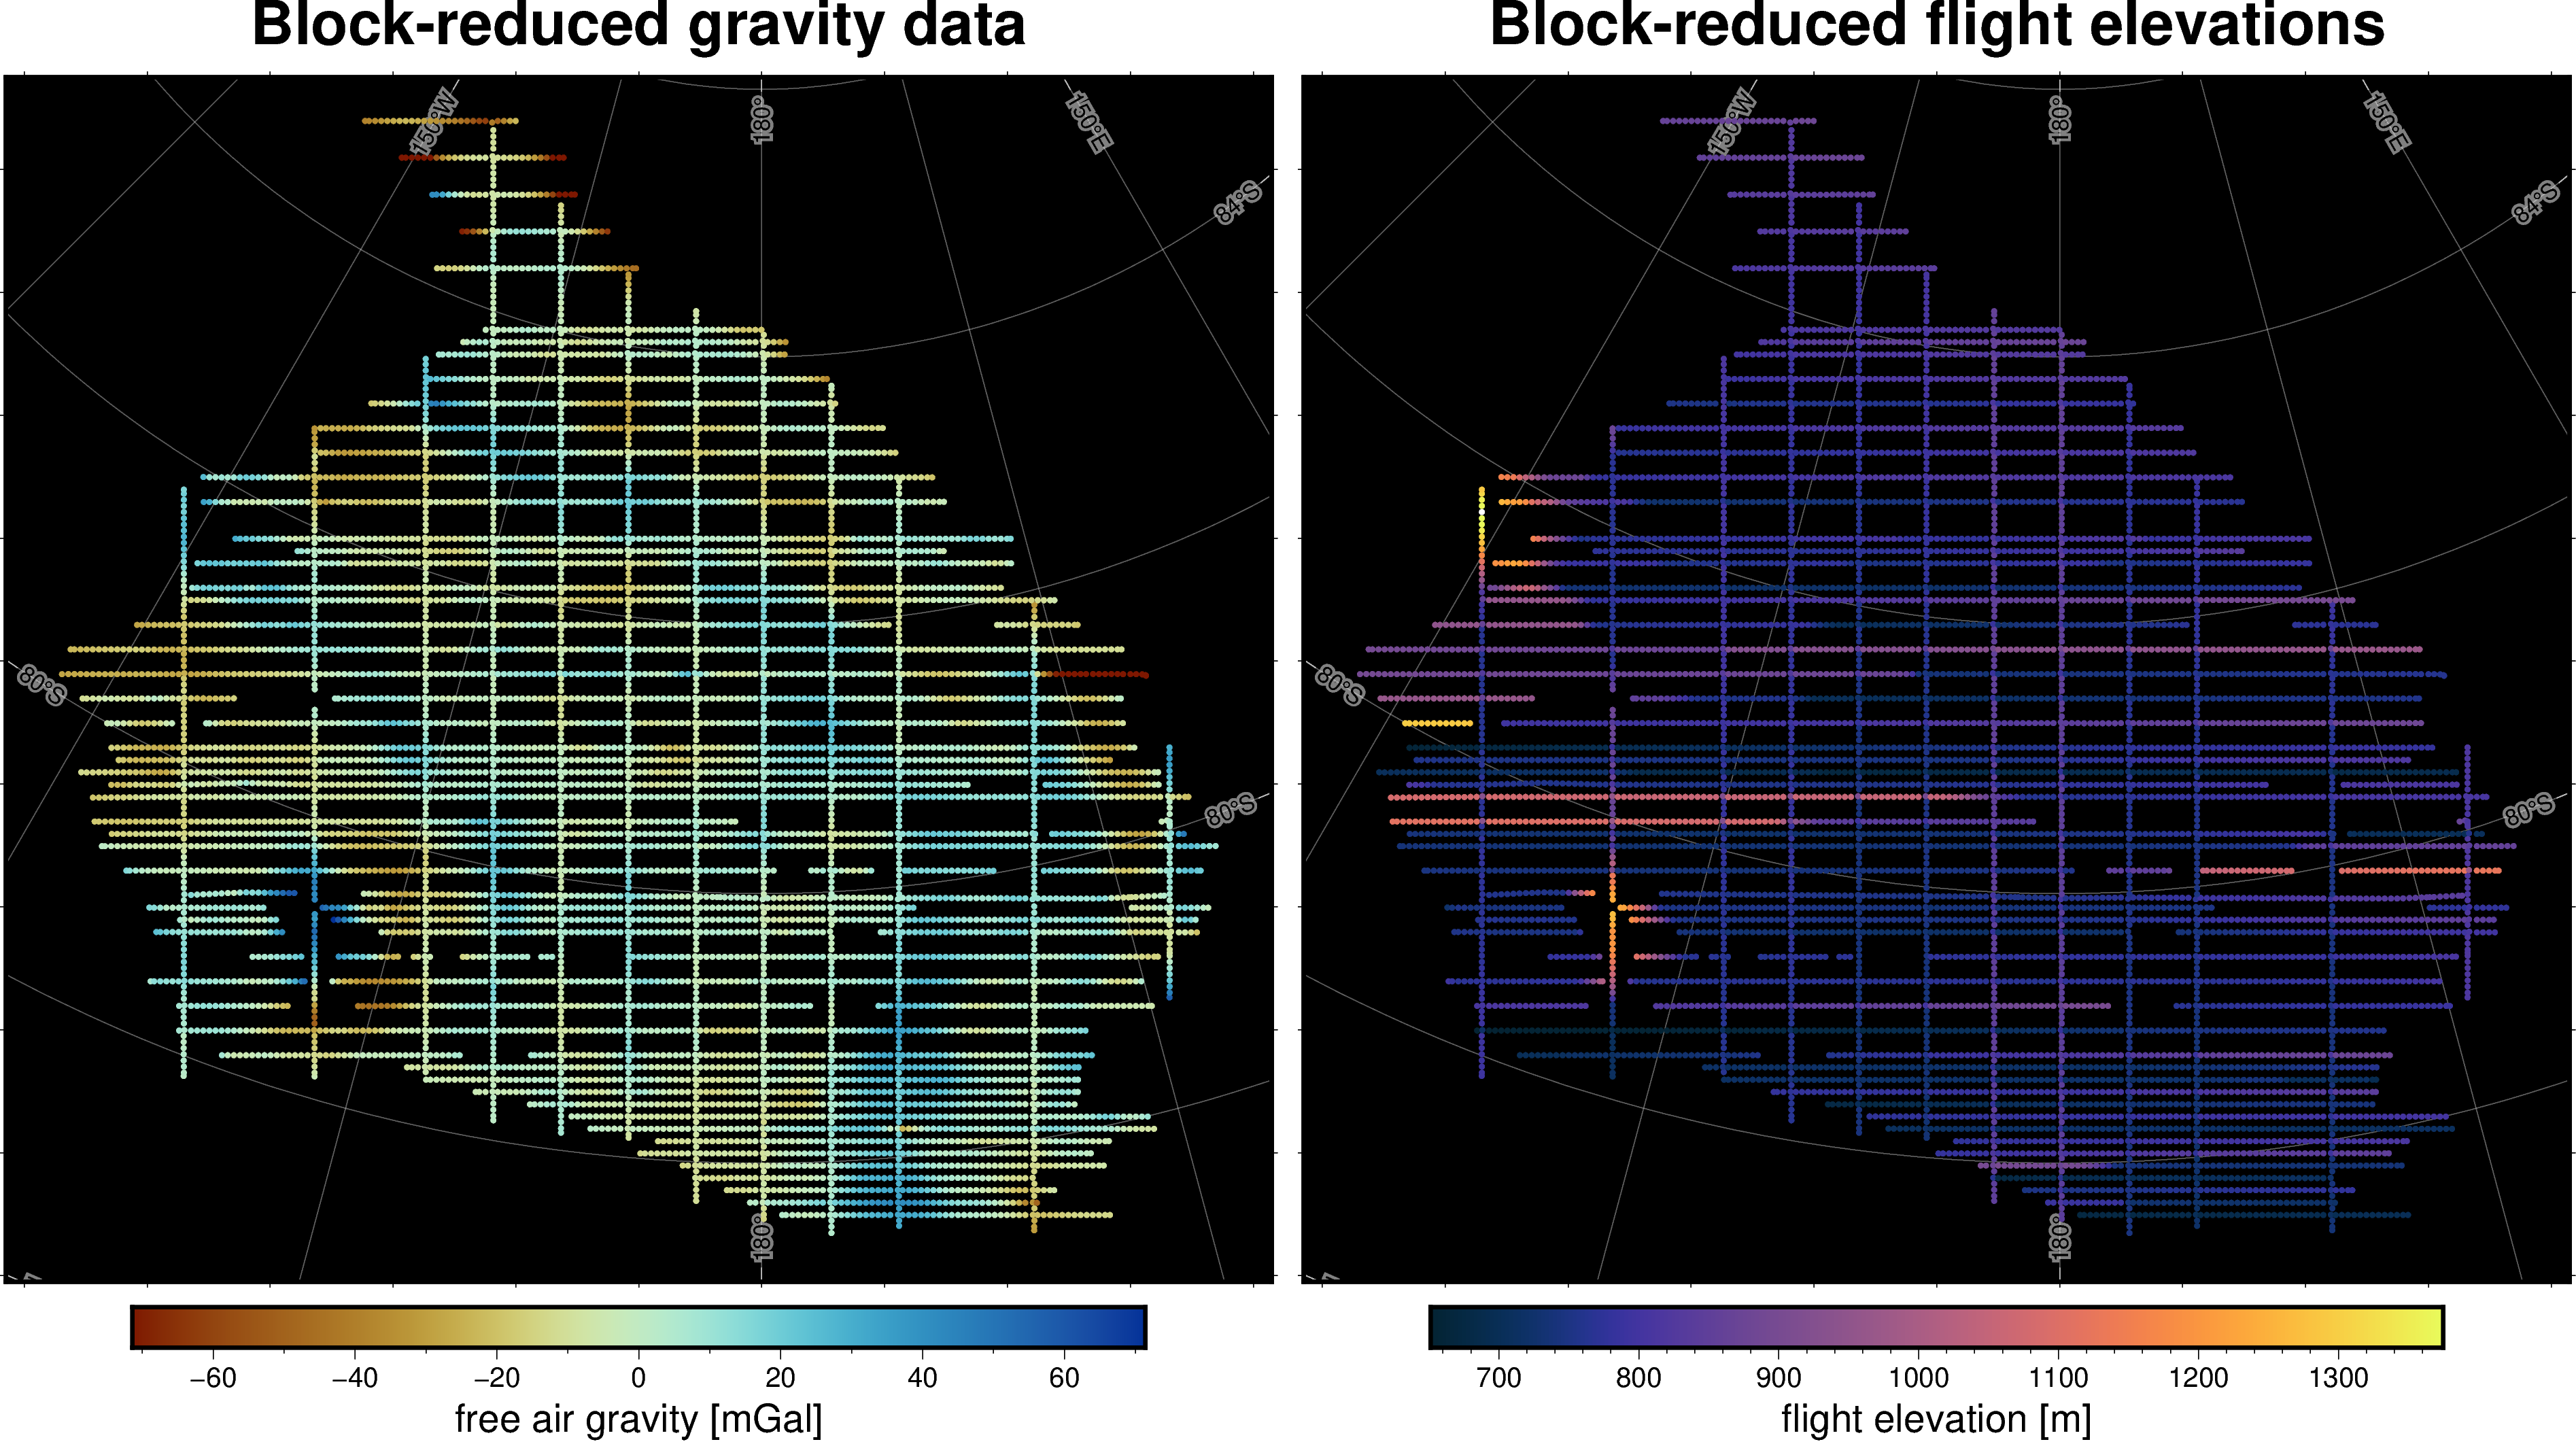

In [8]:
# set up parameters for a block reduction
reducer = vd.BlockReduce(
    reduction=np.mean, 
    # reduction=np.median, 
    spacing=5e3, 
    center_coordinates=False,
    # center_coordinates=True, # get average coordinate, not the center
    )

# get the mean/median gravity anomaly and flight elevation within each block
coordinates, data = reducer.filter(
    coordinates=(rosetta.x, rosetta.y), data=(rosetta.FAG_levelled, rosetta.Height))
# put results into dataframe
df = pd.DataFrame(data={'x': coordinates[0], 'y':coordinates[1], 'FAG_levelled':data[0], 'elev':data[1]})

# plot a basemap
fig = maps.basemap(
    region, 
    title="Block-reduced gravity data",
    background='black',
    )

# get a quarter of max absolute value and make a colorscale
maxabs = vd.maxabs(df.FAG_levelled)*.25
pygmt.makecpt(cmap="roma", series=[-maxabs,maxabs])

# plot gravity data
fig.plot(x=df.x, 
         y=df.y, 
         color=df.FAG_levelled,
         style='c2p',
         cmap=True)

# plot the colorbar
fig.colorbar(frame='af+l"free air gravity [mGal]"')


# add a second figure to the right
fig = maps.basemap(
    region, 
    title="Block-reduced flight elevations",
    origin_shift='xshift',
    fig=fig,
    background='black',
    )

# make a colorscale for flight elevations 
pygmt.makecpt(cmap="thermal", series=[df.elev.min(), df.elev.max()])

# plot flight elevation data
fig.plot(x=df.x, 
         y=df.y, 
         color=df.elev,
         style='c2p',
         cmap=True)

# plot the colorbar
fig.colorbar(frame='af+l"flight elevation [m]"')

fig.show()

## remove outliers

                   x             y  FAG_levelled         elev       zscore
count    7185.000000  7.185000e+03   7185.000000  7185.000000  7185.000000
mean   -85130.686232 -1.000598e+06     -0.174171   794.774991     0.663194
std    216707.838680  1.982769e+05     14.977596    86.214410     0.748500
min   -569306.933744 -1.365286e+06   -285.495163   651.087333     0.000181
25%   -244809.099852 -1.160504e+06     -7.500035   745.215020     0.229606
50%    -80040.915334 -1.010416e+06      0.199235   775.992293     0.509822
75%     84696.668212 -8.504525e+05      7.868218   820.331627     0.903796
max    369269.342582 -4.604571e+05     72.741864  1374.933457    19.051178


<AxesSubplot: >

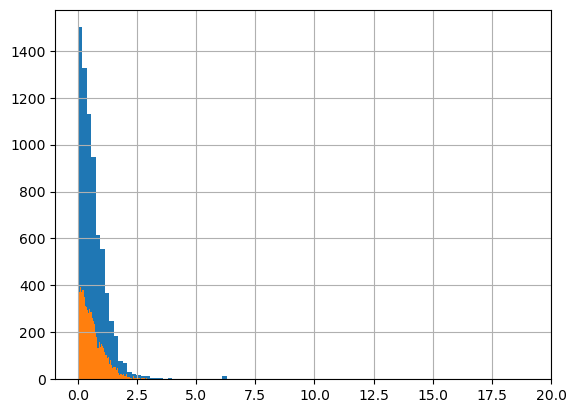

In [9]:
df['zscore']=np.abs(stats.zscore(df.FAG_levelled))
df.sort_values(by='zscore', ascending=False, inplace=True)
df.zscore.hist(bins=100)
print(df.describe())
# dropped base on z-score
df_cleaned=df[df.zscore < 5].copy()
df_outliers=df[df.zscore >= 5].copy()

# reset gravity at 0
df_cleaned['FAG_levelled'] -= df_cleaned.FAG_levelled.mean() 
df_cleaned.zscore.hist(bins=100)

Plot outliers and cleaned gravity data

gmtset [WARNING]: Representation of font type not recognized. Using default.
gmtset [WARNING]: Representation of font type not recognized. Using default.


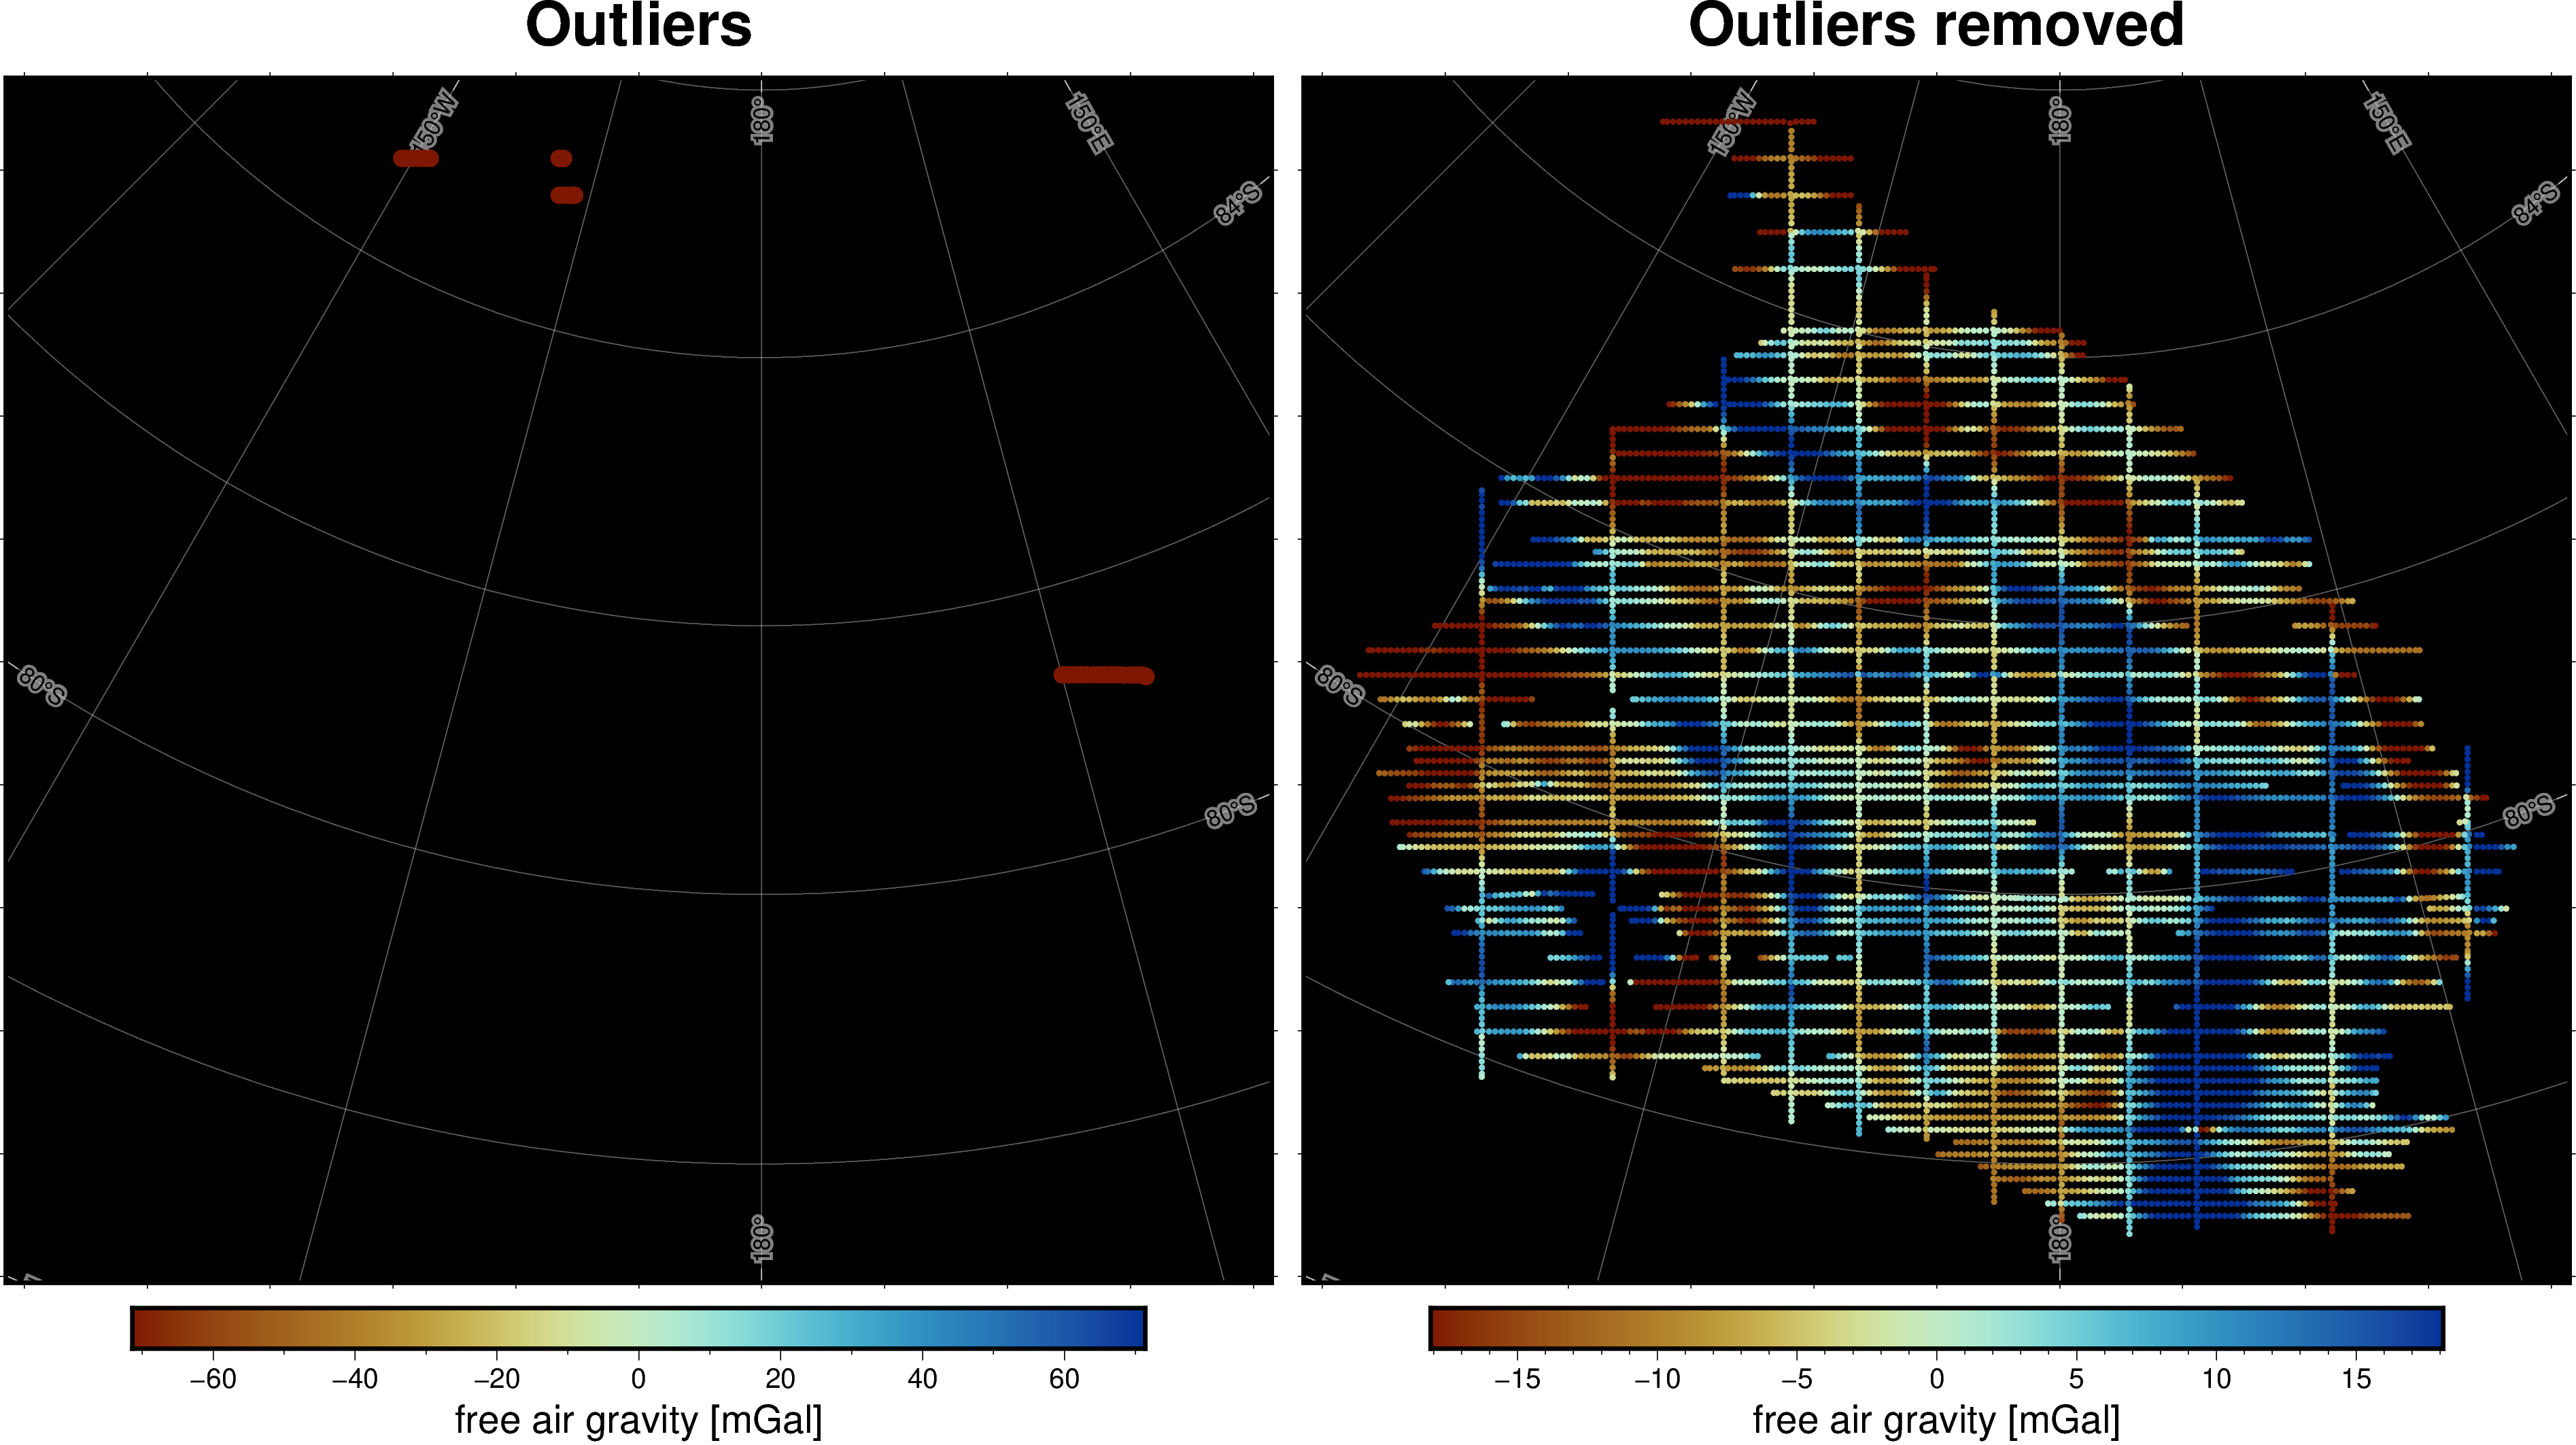

In [10]:
# plot a basemap
fig = maps.basemap(
    region, 
    title="Outliers",
    background='black',
    )

# get a quarter of max absolute value and make a colorscale
maxabs = vd.maxabs(df_outliers.FAG_levelled)*.25
pygmt.makecpt(cmap="roma", series=[-maxabs,maxabs])

# plot gravity data
fig.plot(x=df_outliers.x, 
         y=df_outliers.y, 
         color=df_outliers.FAG_levelled,
         style='c6p',
         cmap=True)

# plot the colorbar
fig.colorbar(frame='af+l"free air gravity [mGal]"')


# add a second figure to the right
fig = maps.basemap(
    region, 
    title="Outliers removed",
    origin_shift='xshift',
    fig=fig,
    background='black',
    )

# get a quarter of max absolute value and make a colorscale
maxabs = vd.maxabs(df_cleaned.FAG_levelled)*.25
pygmt.makecpt(cmap="roma", series=[-maxabs,maxabs])

# plot gravity data
fig.plot(x=df_cleaned.x, 
         y=df_cleaned.y, 
         color=df_cleaned.FAG_levelled,
         style='c2p',
         cmap=True)

# plot the colorbar
fig.colorbar(frame='af+l"free air gravity [mGal]"')

fig.show()

## create equivalent sources

In [11]:
coordinates = (df_cleaned.x, df_cleaned.y, df_cleaned.elev) 
eqs_first_guess = hm.EquivalentSources(
    depth=10e3, 
    block=5e3,
    # depth_type='constant', # make the depths constant, not relative to obs elev. # not conclusive for which is best in Soler and Uieda 2021
    damping=10) # high makes smoother predictions, lower can overfit / produce artifacts
eqs_first_guess.fit(coordinates, df_cleaned.FAG_levelled)

EquivalentSources(damping=10, depth=10000.0)

In [12]:
df_cleaned['first_guess_disturbance'] = eqs_first_guess.predict(coordinates)
df_cleaned.describe()

x             y  FAG_levelled         elev       zscore  \
count    7157.000000  7.157000e+03  7.157000e+03  7157.000000  7157.000000   
mean   -85722.459447 -1.001637e+06  9.530823e-17   794.737668     0.635298   
std    216349.448792  1.975562e+05  1.258551e+01    86.329743     0.550866   
min   -569306.933744 -1.365286e+06 -7.221830e+01   651.087333     0.000181   
25%   -244810.670570 -1.160506e+06 -7.685469e+00   745.069520     0.228957   
50%    -80045.124398 -1.010432e+06 -3.534268e-02   775.998528     0.507325   
75%     84686.305528 -8.504530e+05  7.622123e+00   820.235080     0.897971   
max    369269.342582 -4.604571e+05  7.245940e+01  1374.933457     4.868679   

       first_guess_disturbance  
count              7157.000000  
mean                  0.000070  
std                  12.498866  
min                 -69.597653  
25%                  -7.600618  
50%                  -0.027042  
75%                   7.618331  
max                  66.708382

In [13]:
score_first_guess = np.mean(
    vd.cross_val_score(
        eqs_first_guess,
        coordinates,
        df_cleaned.FAG_levelled,
    )
)
score_first_guess

0.9690121408449164

In [14]:
dampings = [0.01, 0.1, 1, 10,]
depths = [5e3, 10e3, 20e3, 50e3]

import itertools

parameter_sets = [
    dict(damping=combo[0], depth=combo[1])
    for combo in itertools.product(dampings, depths)
]
print("Number of combinations:", len(parameter_sets))
print("Combinations:", parameter_sets)

Number of combinations: 16
Combinations: [{'damping': 0.01, 'depth': 5000.0}, {'damping': 0.01, 'depth': 10000.0}, {'damping': 0.01, 'depth': 20000.0}, {'damping': 0.01, 'depth': 50000.0}, {'damping': 0.1, 'depth': 5000.0}, {'damping': 0.1, 'depth': 10000.0}, {'damping': 0.1, 'depth': 20000.0}, {'damping': 0.1, 'depth': 50000.0}, {'damping': 1, 'depth': 5000.0}, {'damping': 1, 'depth': 10000.0}, {'damping': 1, 'depth': 20000.0}, {'damping': 1, 'depth': 50000.0}, {'damping': 10, 'depth': 5000.0}, {'damping': 10, 'depth': 10000.0}, {'damping': 10, 'depth': 20000.0}, {'damping': 10, 'depth': 50000.0}]


In [15]:
equivalent_sources = hm.EquivalentSources()

scores = []
for params in parameter_sets:
    equivalent_sources.set_params(**params)
    score = np.mean(
        vd.cross_val_score(
            equivalent_sources,
            coordinates,
            df_cleaned.FAG_levelled,
        )
    )
    scores.append(score)
scores

[0.9640483647824716,
 0.9724201635992445,
 0.9739273880418047,
 0.9310816708828226,
 0.964038632199739,
 0.9734499605355198,
 0.9705197892138193,
 0.9139609309695971,
 0.963943489680541,
 0.9735816138649659,
 0.961379379073192,
 0.8919433164568323,
 0.9630524625549903,
 0.9690121408449164,
 0.9444058437731749,
 0.8545004511289923]

In [16]:
best = np.argmax(scores)
print("Best score:", scores[best])
print("Score with defaults:", score_first_guess)
print("Best parameters:", parameter_sets[best])

Best score: 0.9739273880418047
Score with defaults: 0.9690121408449164
Best parameters: {'damping': 0.01, 'depth': 20000.0}


In [17]:
eqs_best = hm.EquivalentSources(**parameter_sets[best]).fit(
    coordinates, df_cleaned.FAG_levelled
)

In [18]:
# Define grid coordinates
# region = vd.get_region(coordinates)
grid_coords = vd.grid_coordinates(
    region=region,
    spacing=5e3,
    extra_coords=1e3, # upward continue to 1km
)

grid_first_guess = eqs_first_guess.grid(grid_coords)
grid = eqs_best.grid(grid_coords)

# Predict values at obs points
df_cleaned['best_disturbance'] = eqs_best.predict(coordinates)
df_cleaned['first_guess_disturbance'] = eqs_first_guess.predict(coordinates)
df_cleaned.describe()

x             y  FAG_levelled         elev       zscore  \
count    7157.000000  7.157000e+03  7.157000e+03  7157.000000  7157.000000   
mean   -85722.459447 -1.001637e+06  9.530823e-17   794.737668     0.635298   
std    216349.448792  1.975562e+05  1.258551e+01    86.329743     0.550866   
min   -569306.933744 -1.365286e+06 -7.221830e+01   651.087333     0.000181   
25%   -244810.670570 -1.160506e+06 -7.685469e+00   745.069520     0.228957   
50%    -80045.124398 -1.010432e+06 -3.534268e-02   775.998528     0.507325   
75%     84686.305528 -8.504530e+05  7.622123e+00   820.235080     0.897971   
max    369269.342582 -4.604571e+05  7.245940e+01  1374.933457     4.868679   

       first_guess_disturbance  best_disturbance  
count              7157.000000       7157.000000  
mean                  0.000070          0.000003  
std                  12.498866         12.539680  
min                 -69.597653        -71.967084  
25%                  -7.600618         -7.612527  
50%                  -0.027042         -0.041672  
75%                   7.618331          7.633021  
max                  66.708382         69.517281

returning original grid
returning original grid


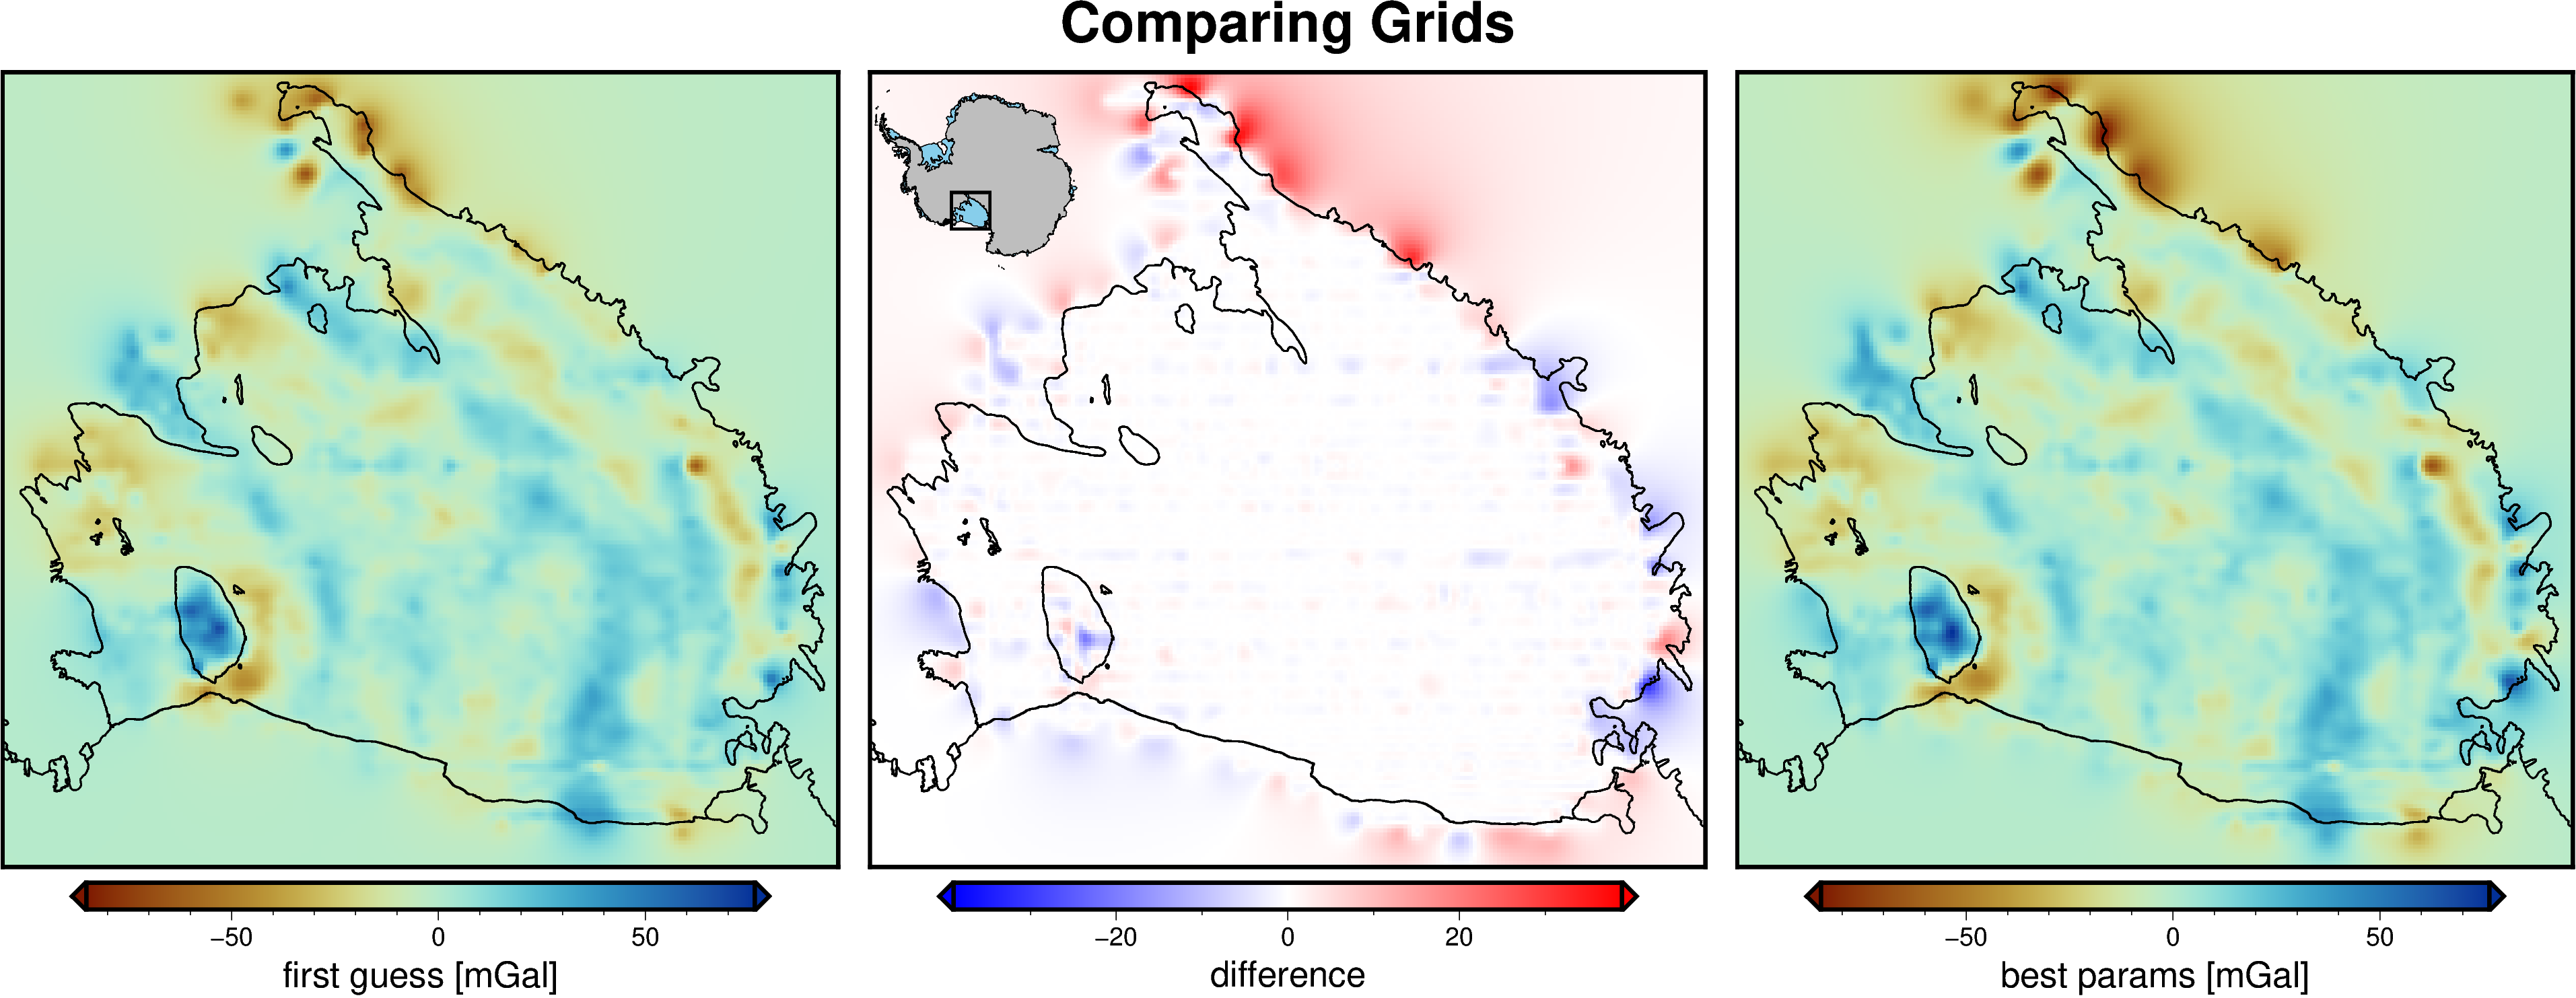

In [19]:
grids = utils.grd_compare(
    grid_first_guess.scalars,
    grid.scalars,
    plot=True,
    grid1_name="first guess [mGal]",
    grid2_name="best params [mGal]",
    cmap="roma",
    )

gmtset [WARNING]: Representation of font type not recognized. Using default.
gmtset [WARNING]: Representation of font type not recognized. Using default.
gmtset [WARNING]: Representation of font type not recognized. Using default.


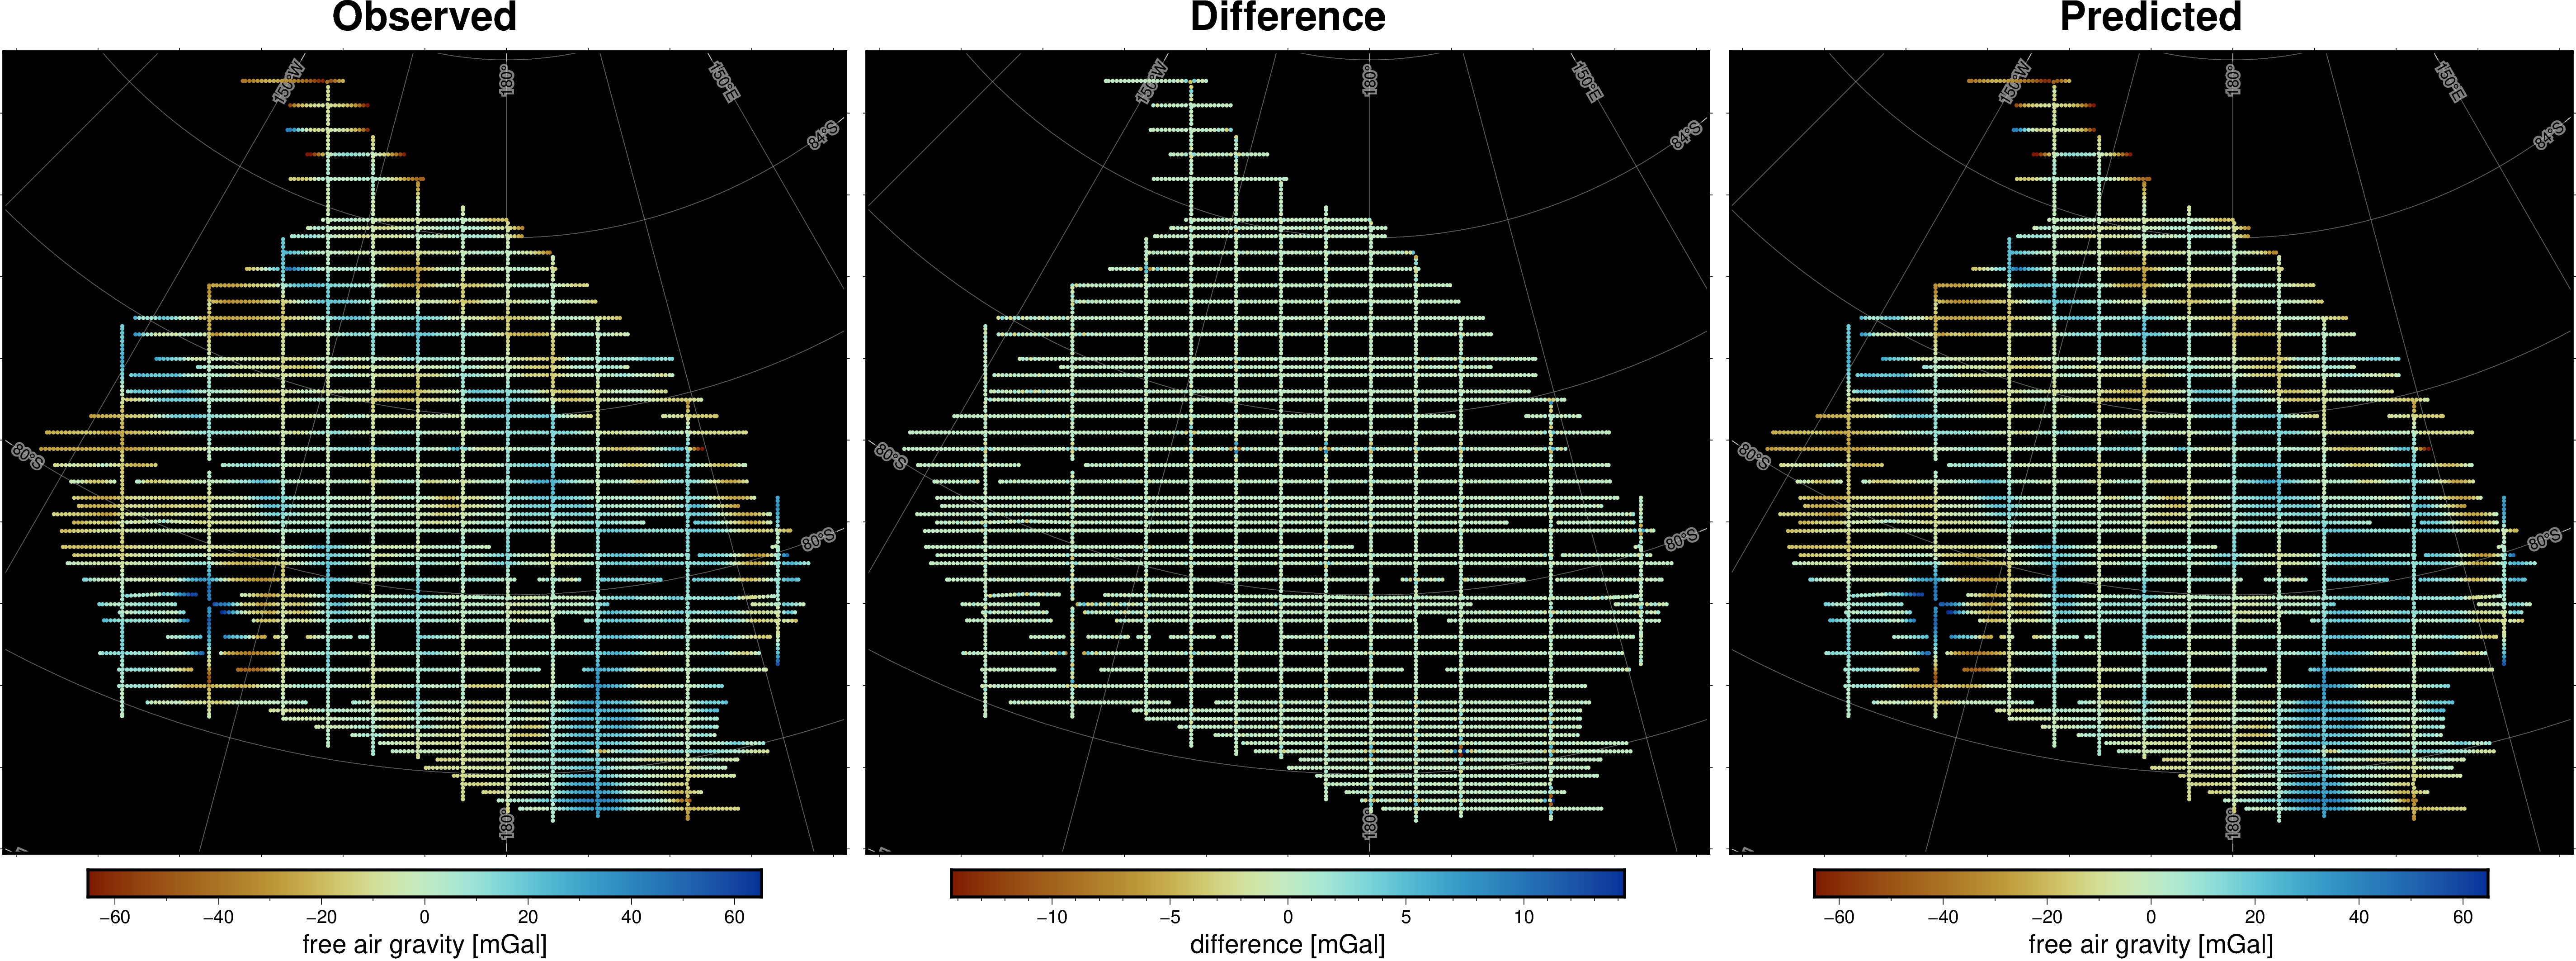

<AxesSubplot: >

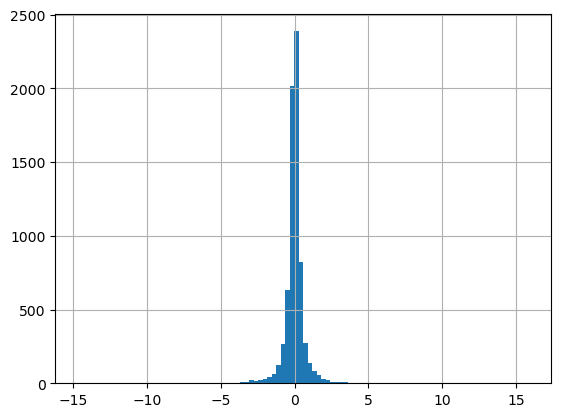

In [20]:
# plot a basemap
fig = maps.basemap(
    region, 
    title="Observed",
    background='black',
    )

# get a quarter of max absolute value and make a colorscale
maxabs = vd.maxabs(df_cleaned.FAG_levelled)*.9
pygmt.makecpt(cmap="roma", series=[-maxabs,maxabs])

# plot gravity data
fig.plot(x=df_cleaned.x, 
         y=df_cleaned.y, 
         color=df_cleaned.FAG_levelled,
         style='c2p',
         cmap=True)

# plot the colorbar
fig.colorbar(frame='af+l"free air gravity [mGal]"')


# add a second figure to the right
fig = maps.basemap(
    region, 
    title="Difference",
    origin_shift='xshift',
    fig=fig,
    background='black',
    )

# get a quarter of max absolute value and make a colorscale
dif = df_cleaned.best_disturbance - df_cleaned.FAG_levelled
maxabs = vd.maxabs(dif)*.9
pygmt.makecpt(cmap="roma", series=[-maxabs,maxabs])

# plot gravity data
fig.plot(x=df_cleaned.x, 
         y=df_cleaned.y, 
         color=dif,
         style='c2p',
         cmap=True)

# plot the colorbar
fig.colorbar(frame='af+l"difference [mGal]"')


# plot a third figure
fig = maps.basemap(
    region, 
    title="Predicted",
    origin_shift='xshift',
    fig=fig,
    background='black',
    )

# get a quarter of max absolute value and make a colorscale
maxabs = vd.maxabs(df_cleaned.best_disturbance)*.9
pygmt.makecpt(cmap="roma", series=[-maxabs,maxabs])

# plot gravity data
fig.plot(x=df_cleaned.x, 
         y=df_cleaned.y, 
         color=df_cleaned.best_disturbance,
         style='c2p',
         cmap=True)

# plot the colorbar
fig.colorbar(frame='af+l"free air gravity [mGal]"')

fig.show()

dif.hist(bins=100)

compare with orginal grid

returning original grid
returning grid with new region and/or registration, same spacing


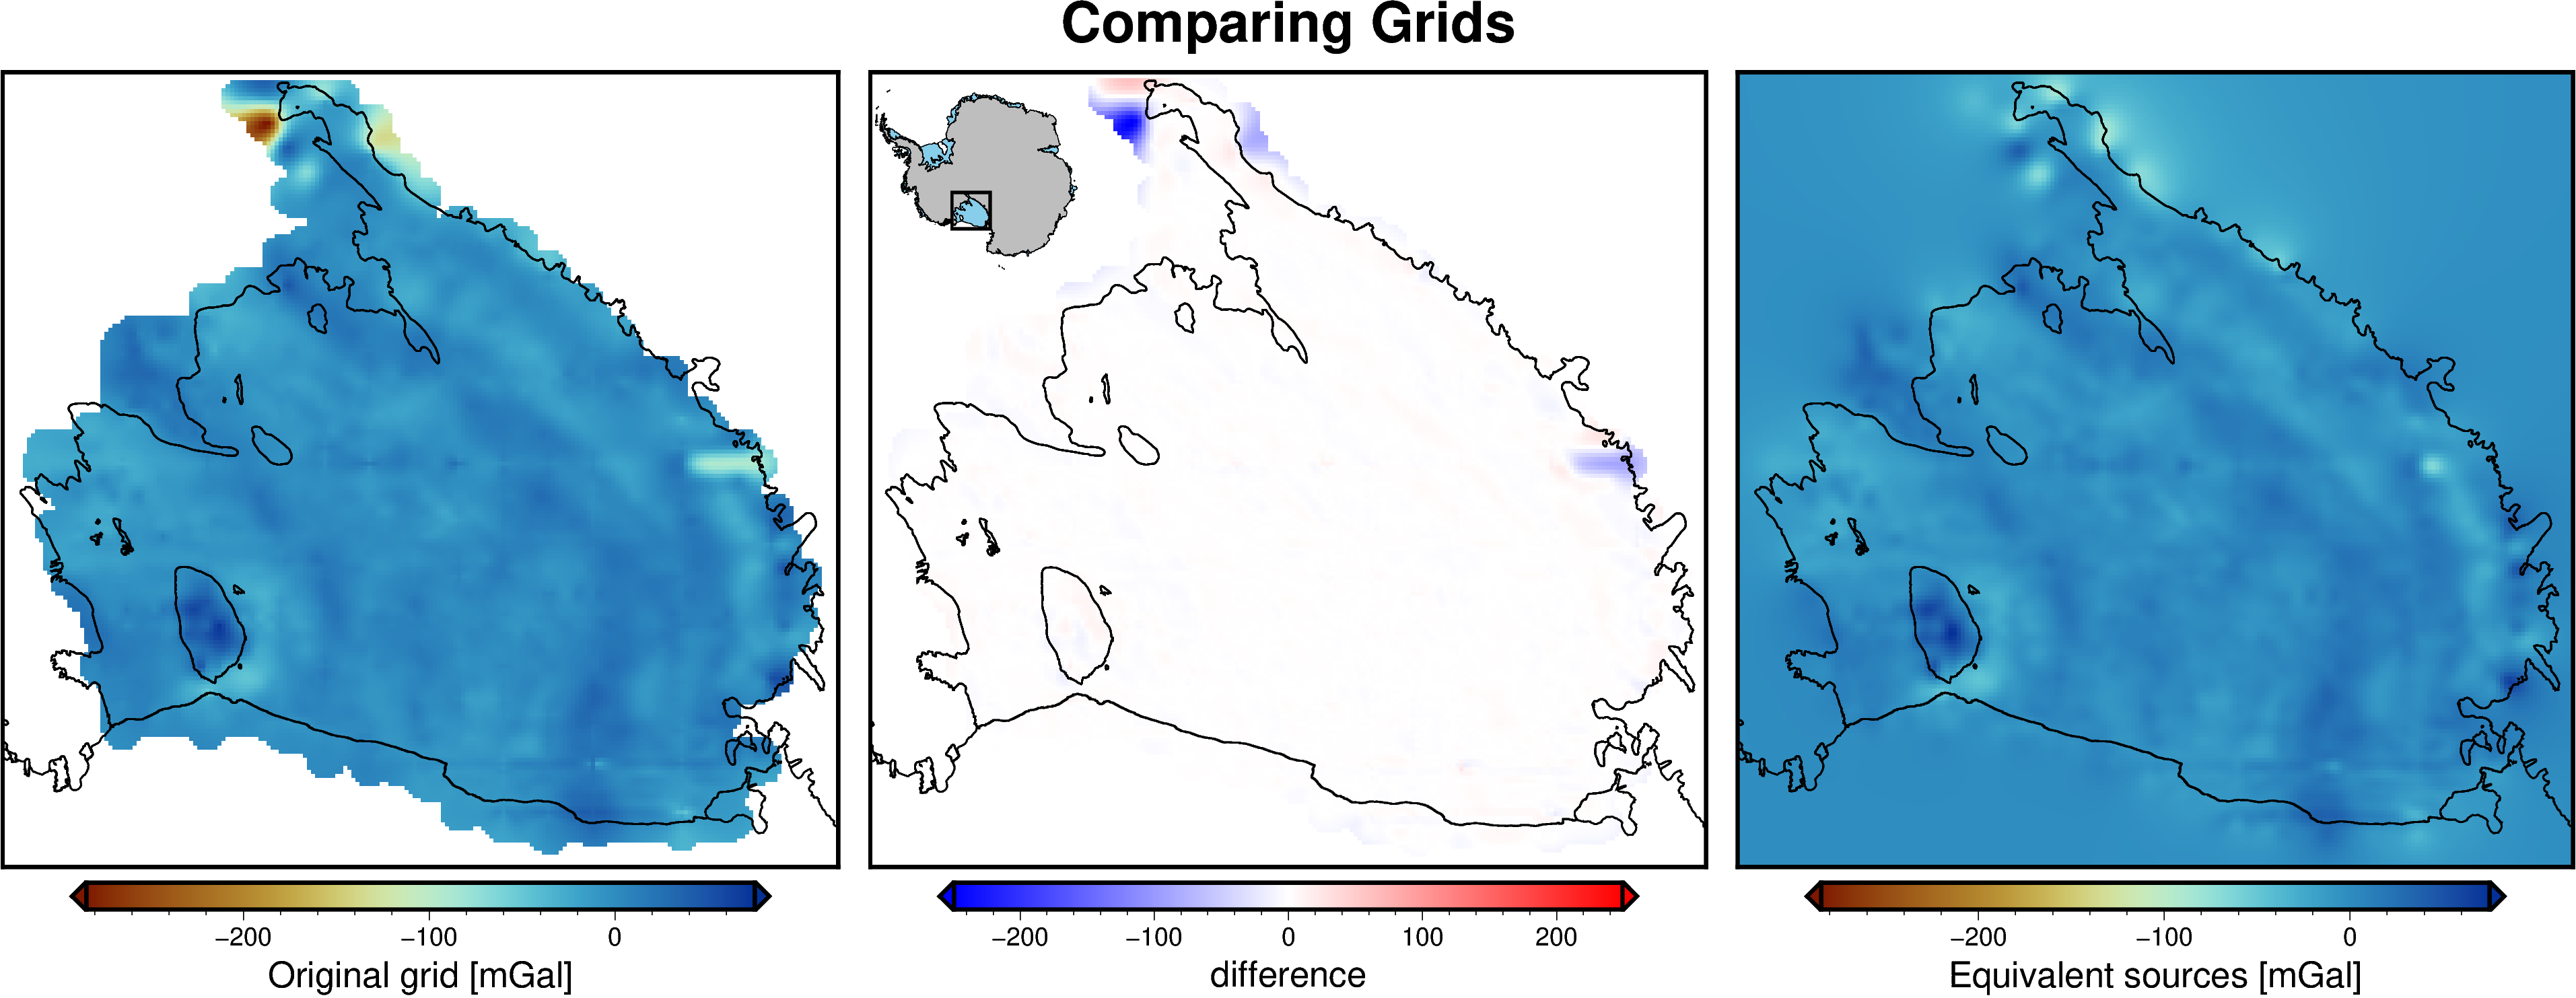

In [21]:
grids = utils.grd_compare(
    rosetta_grav_grid,
    grid.scalars,
    plot=True,
    grid1_name="Original grid [mGal]",
    grid2_name="Equivalent sources [mGal]",
    cmap="roma",
    )

## compare upward continue amounts

1374.9334565217391

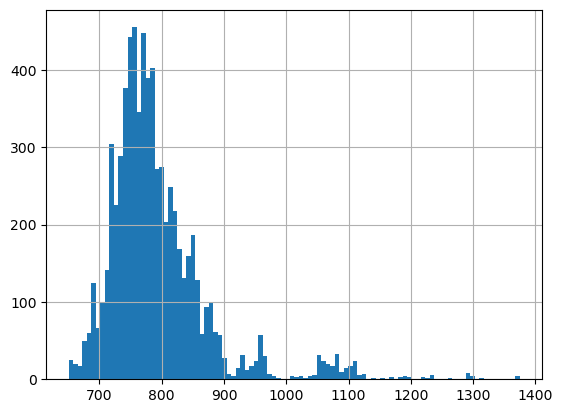

In [22]:
df_cleaned.elev.hist(bins=100)
df_cleaned.elev.max()

returning original grid
returning original grid


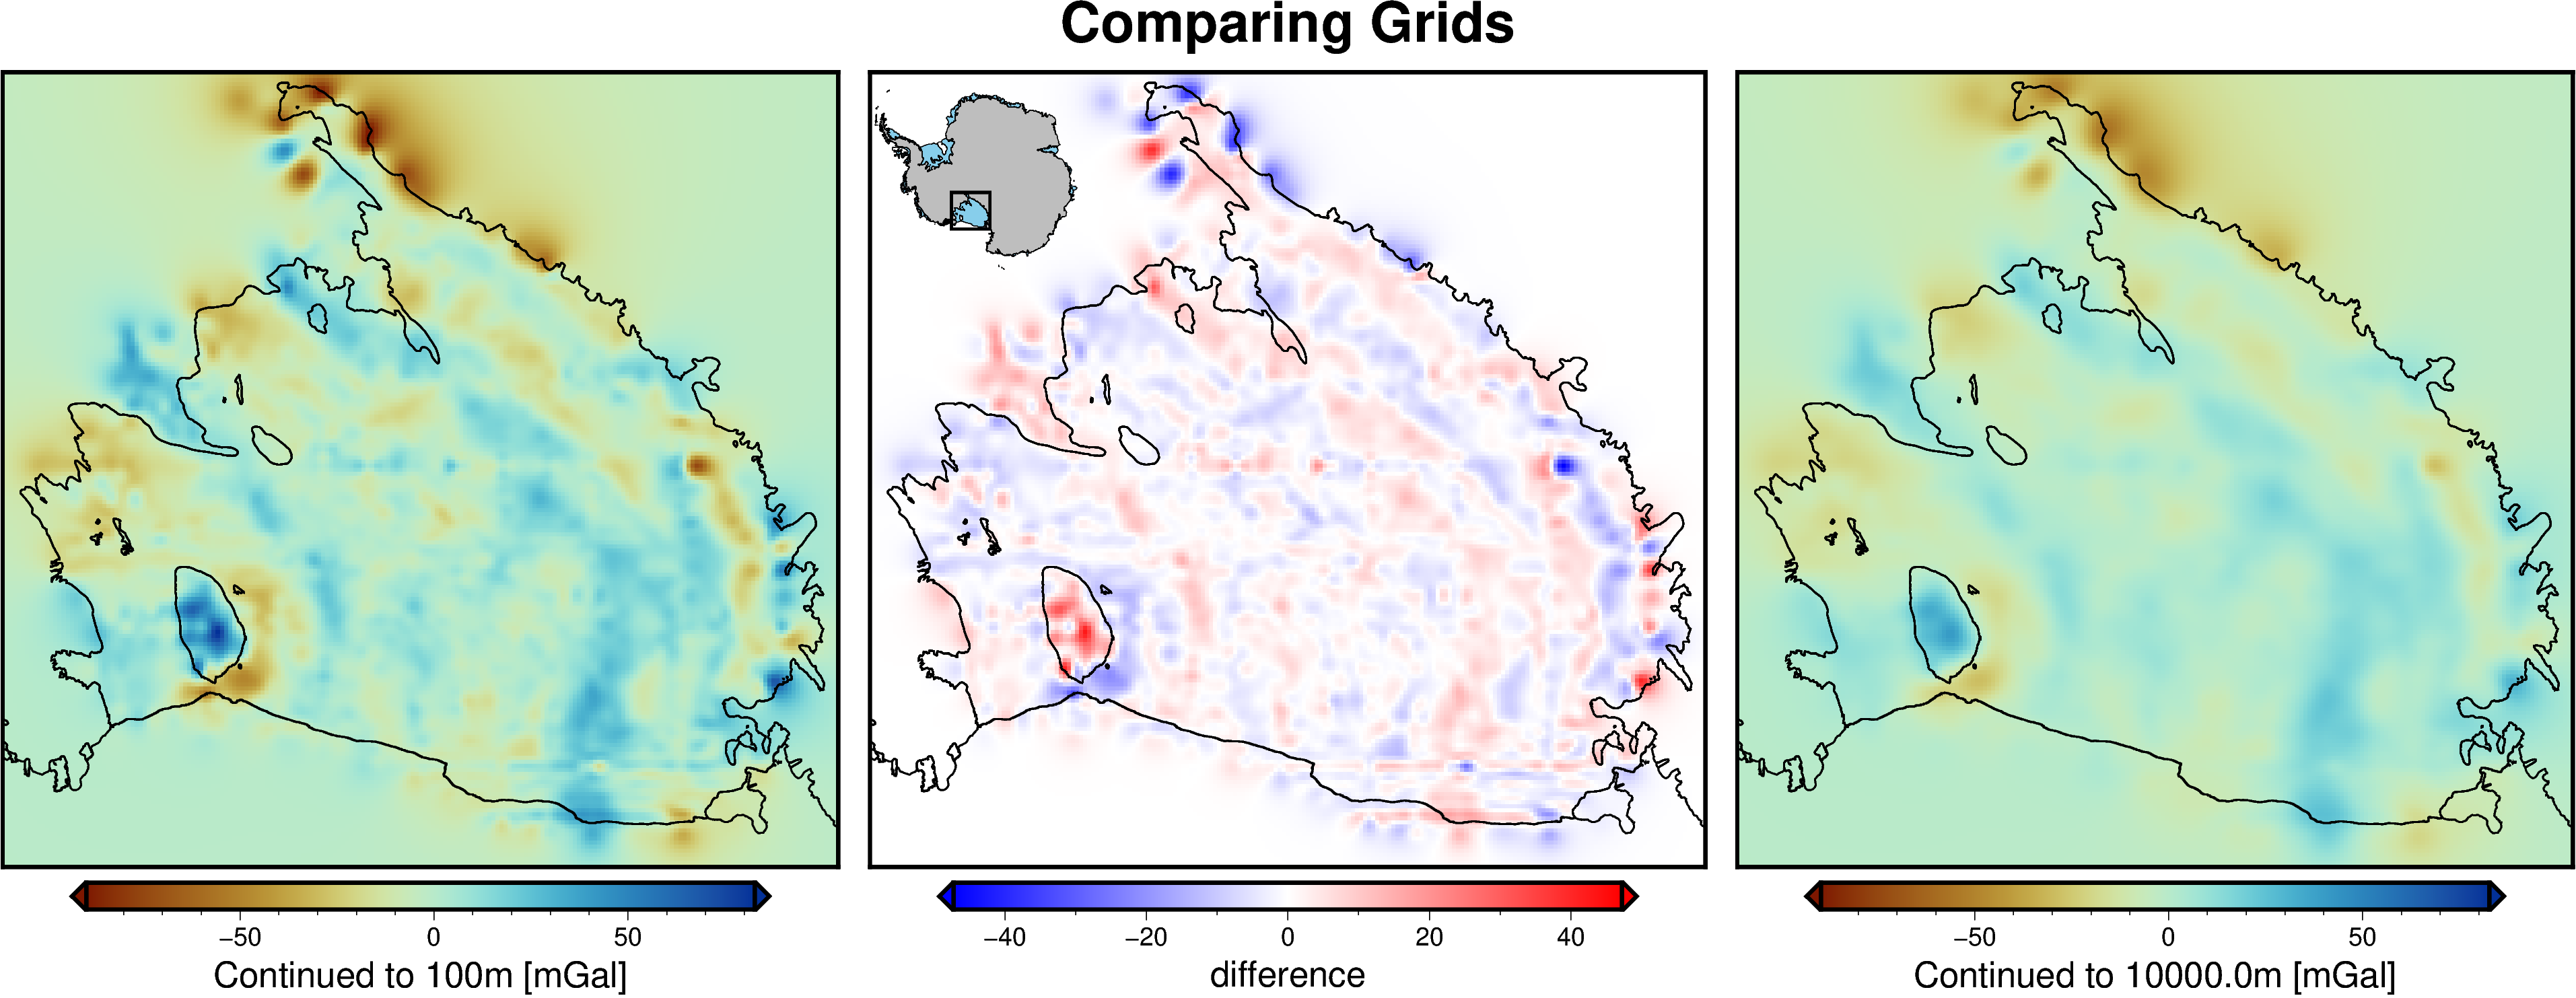

In [24]:
# Build the grid coordinates
# region = vd.get_region(coordinates)

low=100
grid_coords_low = vd.grid_coordinates(region=region, spacing=5e3, extra_coords=low)
high=10e3
grid_coords_high = vd.grid_coordinates(region=region, spacing=5e3, extra_coords=high)

# Grid the gravity disturbances
grid_low = eqs_best.grid(grid_coords_low, data_names=["gravity_disturbance"])
grid_high = eqs_best.grid(grid_coords_high, data_names=["gravity_disturbance"])

grids = utils.grd_compare(
   grid_low.gravity_disturbance,
   grid_high.gravity_disturbance,
   plot=True,
   grid1_name=f"Continued to {low}m [mGal]",
   grid2_name=f"Continued to {high}m [mGal]",
   cmap="roma",
   )

## mask grid

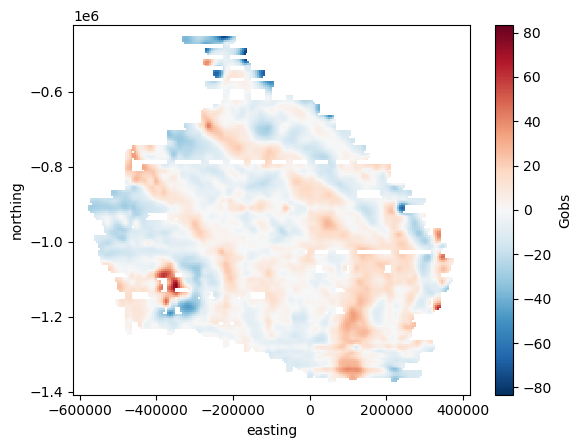

In [25]:
up_con_elev = 1e3
grid_coords = vd.grid_coordinates(region=region, spacing=5e3, extra_coords=up_con_elev)

# Grid the gravity disturbances
grid = eqs_best.grid(grid_coords, data_names=["Gobs"])
masked = vd.distance_mask((df_cleaned.x, df_cleaned.y), maxdist=10e3, grid=grid)
masked['height']=masked.upward
masked.Gobs.plot()

## save as netcdf

In [31]:
pygmt.grdsample(
            grid=masked.height,
            region=[-580000, 420000, -1420000, -420000], 
            registration='p', 
            spacing="5000+e",
            outgrid='gravity_data/rosetta_eq_source_up_continued_elev.nc',
            ) 
pygmt.grdsample(
            grid=masked.Gobs,
            region=[-580000, 420000, -1420000, -420000], 
            registration='p', 
            spacing="5000+e",
            outgrid='gravity_data/rosetta_eq_source_up_continued_Gobs.nc',
            ) 

## save as .csv

In [32]:
up_con_elev=1e3
grav = xr.load_dataarray('gravity_data/rosetta_eq_source_up_continued_Gobs.nc')
df = vd.grid_to_table(grav)
df.rename(columns={'z':'Gobs'}, inplace=True)

df['z'] = up_con_elev
df.dropna(inplace=True)
df = df[['x','y','Gobs','z']]
df.to_csv('gravity_data/rosetta_eq_source_up_continued.csv', index=False)
df.describe()


x             y          Gobs        z
count   20281.000000  2.028100e+04  20281.000000  20281.0
mean   -94431.857403 -9.846740e+05     -0.468127   1000.0
std    225582.339742  2.006517e+05     13.377435      0.0
min   -577500.000000 -1.372500e+06    -83.057556   1000.0
25%   -267500.000000 -1.142500e+06     -8.136687   1000.0
50%    -97500.000000 -9.925000e+05     -0.211645   1000.0
75%     87500.000000 -8.425000e+05      7.554190   1000.0
max    377500.000000 -4.525000e+05     75.098183   1000.0

In [33]:
df=pd.read_csv('gravity_data/rosetta_eq_source_up_continued.csv', index_col=False)
df

x          y       Gobs       z
0       52500.0 -1372500.0  -2.325155  1000.0
1       57500.0 -1372500.0  -0.258595  1000.0
2      217500.0 -1372500.0 -30.209759  1000.0
3      222500.0 -1372500.0 -32.112520  1000.0
4       47500.0 -1367500.0  -3.554421  1000.0
...         ...        ...        ...     ...
20276 -217500.0  -452500.0 -76.058710  1000.0
20277 -212500.0  -452500.0 -66.737990  1000.0
20278 -207500.0  -452500.0 -53.451897  1000.0
20279 -202500.0  -452500.0 -39.771366  1000.0
20280 -197500.0  -452500.0 -29.851591  1000.0

[20281 rows x 4 columns]

In [35]:
df['Gobs'] -= df.Gobs.mean()
df.describe()

x             y          Gobs        z
count   20281.000000  2.028100e+04  2.028100e+04  20281.0
mean   -94431.857403 -9.846740e+05 -1.793787e-16   1000.0
std    225582.339742  2.006517e+05  1.337743e+01      0.0
min   -577500.000000 -1.372500e+06 -8.258943e+01   1000.0
25%   -267500.000000 -1.142500e+06 -7.668560e+00   1000.0
50%    -97500.000000 -9.925000e+05  2.564826e-01   1000.0
75%     87500.000000 -8.425000e+05  8.022317e+00   1000.0
max    377500.000000 -4.525000e+05  7.556631e+01   1000.0

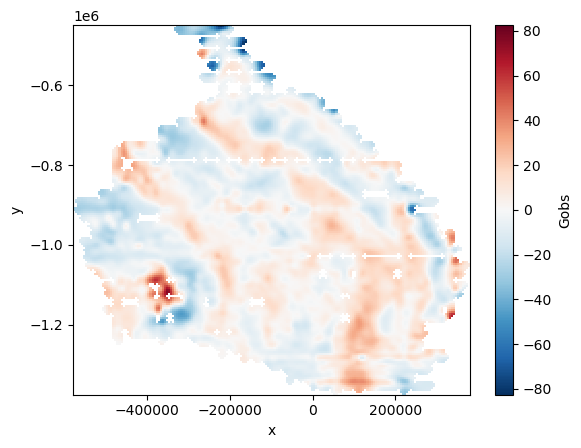

In [36]:
df.set_index(['y','x']).to_xarray().Gobs.plot()

# Updated AntGG compilation

In [ ]:
# forsberg compilation
# includes AngGG, DTU Space, PolarGap, OIB,a ROSETTA, GOCE
# FA is free-air anom at geioid, DG is disturbance (FA at ellipsoid), BA is bouguer anom (free air at sea) 
# antgg_update_tif = rioxarray.open_rasterio('C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/gravity_data/ant4d_fa.tif')
# file ='C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/gravity_data/ant4d_gravity.dat'
file='/Volumes/arc_04/tankerma/Datasets/4D_antarctica_grav/ant4d_gravity/ant4d_gravity.dat'
antgg_update = pd.read_csv(file, delim_whitespace=True, 
                           skiprows=3, names=['id', 'lat', 'lon', 'FA', 'Err', 'DG', 'BA'])

transformer = Transformer.from_crs("epsg:4326", "epsg:3031")
antgg_update['x'], antgg_update['y'] = transformer.transform(antgg_update.lat.tolist(), antgg_update.lon.tolist())

region = vd.get_region((antgg_update.x, antgg_update.y))
antgg_update.describe()

In [ ]:
antgg_update = pygmt.blockmedian(antgg_update[["x", "y", "FA"]], 
                                         spacing="5000+e", 
                                         region=(-3330000, 3330000, -3330000, 3330000))

# antgg_update = antgg_update.set_index(['x', 'y'])

# antgg_update=antgg_update[~antgg_update.index.duplicated()]
# # # antgg_update.to_xarray()
# xr.Dataset.from_dataframe(antgg_update)

fname = 'gravity_data/ant4d_gravity_epsg_5k.nc'
pygmt.surface(data=antgg_update[['x','y','FA']], 
                            spacing=5000, 
                            region=(-3330000, 3330000, -3330000, 3330000),
                            M='2c',
                            outgrid=fname
                            )
# antgg_update_tif
# pygmt.grdfill(grid=antgg_update_grid, mode='n', L=True, region=fig_reg)#, outgrid=fname)

In [ ]:
start_fig()
fname = '/Volumes/arc_04/tankerma/Datasets/4D_antarctica_grav/ant4d_gravity/ant4d_gravity_epsg_5k.nc'
# make color ramp scaled to points
pygmt.grd2cpt(cmap="jet", continuous=True, region=fig_reg, grid=fname)
# pygmt.makecpt(cmap="viridis", series=[antgg_update.FA.min(), antgg_update.FA.max()])

# plot grid      
fig.grdimage(grid=fname,
    cmap=True,
    projection=fig_proj, 
    region=fig_reg,
    frame=['a','+gwhite'],)

fig.colorbar(frame='af+l"observed gravity [mGal]"')

fig.show() 

# Ground Surveys

In [ ]:
file='C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/gravity_data/K863_KIS.csv'
KIS = pd.read_csv(file)

transformer = Transformer.from_crs("epsg:4326", "epsg:3031")
KIS['x'], KIS['y'] = transformer.transform(KIS.Latitude.tolist(), KIS.Longitude.tolist())

KIS

In [ ]:
df=KIS
buffer=10e3
n=df.y.min()-buffer
s=df.y.max()+buffer
e=df.x.min()-buffer
w=df.x.max()+buffer

df=rosetta_block
df = df[df.y.between(n, s) & df.x.between(e, w)]

KIS['FA_shift']=KIS.FA+(df.FA.mean()-KIS.FA.mean())

In [ ]:
df=KIS
buffer=80e3
n=df.y.min()-buffer
s=df.y.max()+buffer
e=df.x.min()-buffer
w=df.x.max()+buffer

start_fig(n=n, s=s, e=e, w=w)


df=KIS
# make color ramp scaled to points
pygmt.makecpt(cmap="jet", series=[df.FA_shift.min(), df.FA_shift.max()], background=True)

# plot points
fig.plot(x=df.x, 
         y=df.y, 
         color=df.FA_shift,
         style='c4p',
         projection = fig_proj,
         region=fig_reg, 
         cmap=True)

df=rosetta_block

# plot points
fig.plot(x=df.x, 
         y=df.y, 
         color=df.FA,
         style='c4p',
         projection = fig_proj,
         region=fig_reg, 
         cmap=True)

fig.colorbar(frame='af+l"FA gravity (mGal)"')

fig.show() 

In [ ]:
file='C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/gravity_data/K863_DD_2feb22.csv'
DD = pd.read_csv(file)
DD.drop(columns=['Free air anomaly', 'Free air effect'], inplace=True)
DD['FA']=DD['Absolute Gravity']-DD['Ellipsoidal gravity']+(DD.Elevation*0.3086)

transformer = Transformer.from_crs("epsg:4326", "epsg:3031")
DD['x'], DD['y'] = transformer.transform(DD.Latitude.tolist(), DD.Longitude.tolist())
DD

In [ ]:
df=DD
buffer=10e3
n=df.y.min()-buffer
s=df.y.max()+buffer
e=df.x.min()-buffer
w=df.x.max()+buffer

df=rosetta_block
df = df[df.y.between(n, s) & df.x.between(e, w)]

DD['FA_shift']=DD.FA+(df.FA.mean()-DD.FA.mean())

start_fig(n=n, s=s, e=e, w=w)


df=DD
# make color ramp scaled to points
pygmt.makecpt(cmap="jet", series=[df.FA_shift.min(), df.FA_shift.max()], background=True)

# plot points
fig.plot(x=df.x, 
         y=df.y, 
         color=df.FA_shift,
         style='c4p',
         projection = fig_proj,
         region=fig_reg, 
         cmap=True)

df=rosetta_block

# plot points
fig.plot(x=df.x, 
         y=df.y, 
         color=df.FA,
         style='c4p',
         projection = fig_proj,
         region=fig_reg, 
         cmap=True)

fig.colorbar(frame='af+l"FA gravity (mGal)"')

fig.show() 

In [ ]:
file='C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/gravity_data/wgz_fa.csv'
WGZ = pd.read_csv(file)
WGZ.rename(columns={'free-air_disturbance(mGal)':'FA', 'PSX(m)':'x', 'PSY(m)':'y'}, inplace=True)
# transformer = Transformer.from_crs("epsg:4326", "epsg:3031")
# WGZ['x'], WGZ['y'] = transformer.transform(WGZ.Latitude.tolist(), WGZ.Longitude.tolist())
WGZ

In [ ]:
df=WGZ
buffer=20e3
n=df.y.min()-buffer
s=df.y.max()+buffer
e=df.x.min()-buffer
w=df.x.max()+buffer

df=rosetta_block
df = df[df.y.between(n, s) & df.x.between(e, w)]

WGZ['FA_shift']=WGZ.FA+(df.FA.mean()-WGZ.FA.mean())

start_fig(n=n, s=s, e=e, w=w)


df=WGZ
# make color ramp scaled to points
pygmt.makecpt(cmap="jet", series=[df.FA_shift.min(), df.FA_shift.max()], background=True)

# plot points
fig.plot(x=df.x, 
         y=df.y, 
         color=df.FA_shift,
         style='c4p',
         projection = fig_proj,
         region=fig_reg, 
         cmap=True)

df=rosetta_block

# plot points
fig.plot(x=df.x, 
         y=df.y, 
         color=df.FA,
         style='c4p',
         projection = fig_proj,
         region=fig_reg, 
         cmap=True)

fig.colorbar(frame='af+l"FA gravity (mGal)"')

fig.show() 